# Linear Regression

## 공통 코드

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import seaborn as sns

import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "regression"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
import warnings
warnings.filterwarnings(action='ignore')

## 평가지표

In [2]:
# 라이브러리를 임포트합니다.
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# 특성 행렬과 타깃 벡터를 만듭니다.
features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   n_informative = 3,
                                   n_targets = 1,
                                   noise = 50,
                                   coef = False,
                                   random_state = 1)

# 선형 회귀 모델을 만듭니다.
ols = LinearRegression()

# 음의 MSE를 사용한 교차검증을 수행합니다.
print(cross_val_score(ols, features, target, scoring='neg_mean_squared_error'))

# R^2를 사용한 교차검증을 수행합니다.
print(cross_val_score(ols, features, target, scoring='r2'))

[-1974.65337976 -2004.54137625 -3935.19355723 -1060.04361386
 -1598.74104702]
[0.8622399  0.85838075 0.74723548 0.91354743 0.84469331]


## 선형 회귀 모델

### 정규 방정식

그림 저장: generated_data_plot


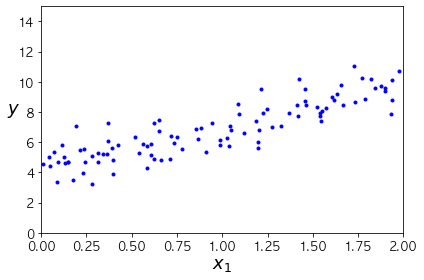

In [3]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [4]:
#모델 파라미터 확인
#모든 샘플에 1을 추가
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.

#inv 함수를 사용해 역행렬을 계산하고 dot() 함수를 사용해서 행렬 곱셈을 수행
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print(theta_best)

[[4.21509616]
 [2.77011339]]


In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
print(y_predict)

[[4.21509616]
 [9.75532293]]


그림 저장: linear_model_predictions_plot


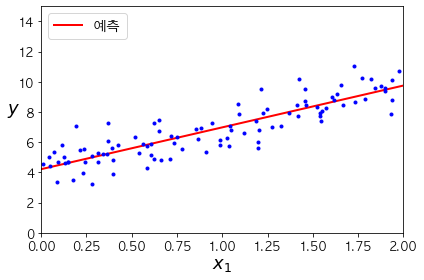

In [6]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="예측")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

### 사이킷 런에서의 선형 회귀

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [9]:
# scipy 의 lstsq() 함수를 사용하려면 scipy.linalg.lstsq(X_b, y)와 같이 사용
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [10]:
#유사 역 행렬
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

### 배치 경사 하강법

In [11]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

print(theta)

[[4.21509616]
 [2.77011339]]


그림 저장: gradient_descent_plot


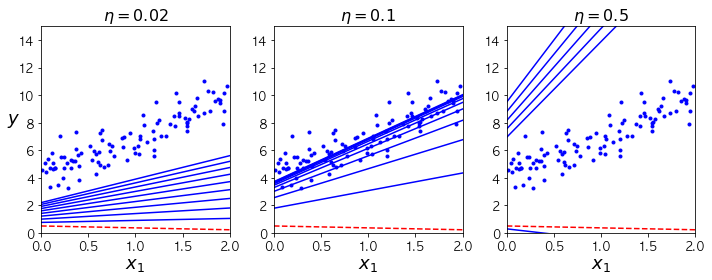

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()    

### 확률적 경사 하강법

[[4.21076011]
 [2.74856079]]
그림 저장: sgd_plot


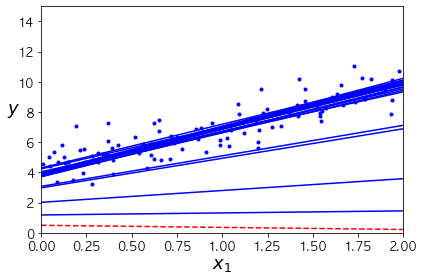

In [13]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

print(theta)
        
plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
save_fig("sgd_plot")                                 
plt.show()                                           

### 사이킷런에서 확률적 경사하강법 구현

In [14]:
from sklearn.linear_model import SGDRegressor

#1000번 에포크 통안 실행(max_iter), 하나의 에포크에서 0.001 보다 적게 손실이 발생할 때 까지 수행(tol) 규제는 없음(penalty), 학습률은 0.1(eta0), 
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 미니 배치 경사하강법

In [15]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
theta

array([[4.25214635],
       [2.7896408 ]])

### 3가지 알고리즘 비교

그림 저장: gradient_descent_paths_plot


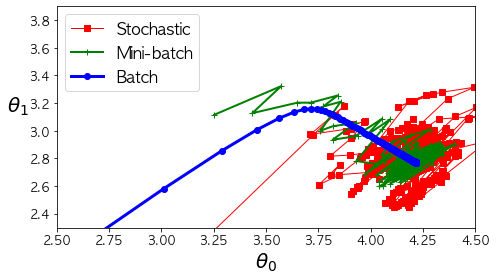

In [16]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## 보스턴 주택 가격 선형 회귀

### 데이터 가져오기

In [17]:
from sklearn.datasets import load_boston

# boston 데이터 세트 로드 
boston = load_boston()
# boston 데이터 세트 DataFrame 변환
bostonDF =pd.DataFrame(boston.data, columns =boston.feature_names)
# boston 데이터 세트의 target 배열은 주택 가격임 . 이를 PRICE 칼럼으로 DataFrame어| 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### 선형 관계 파악

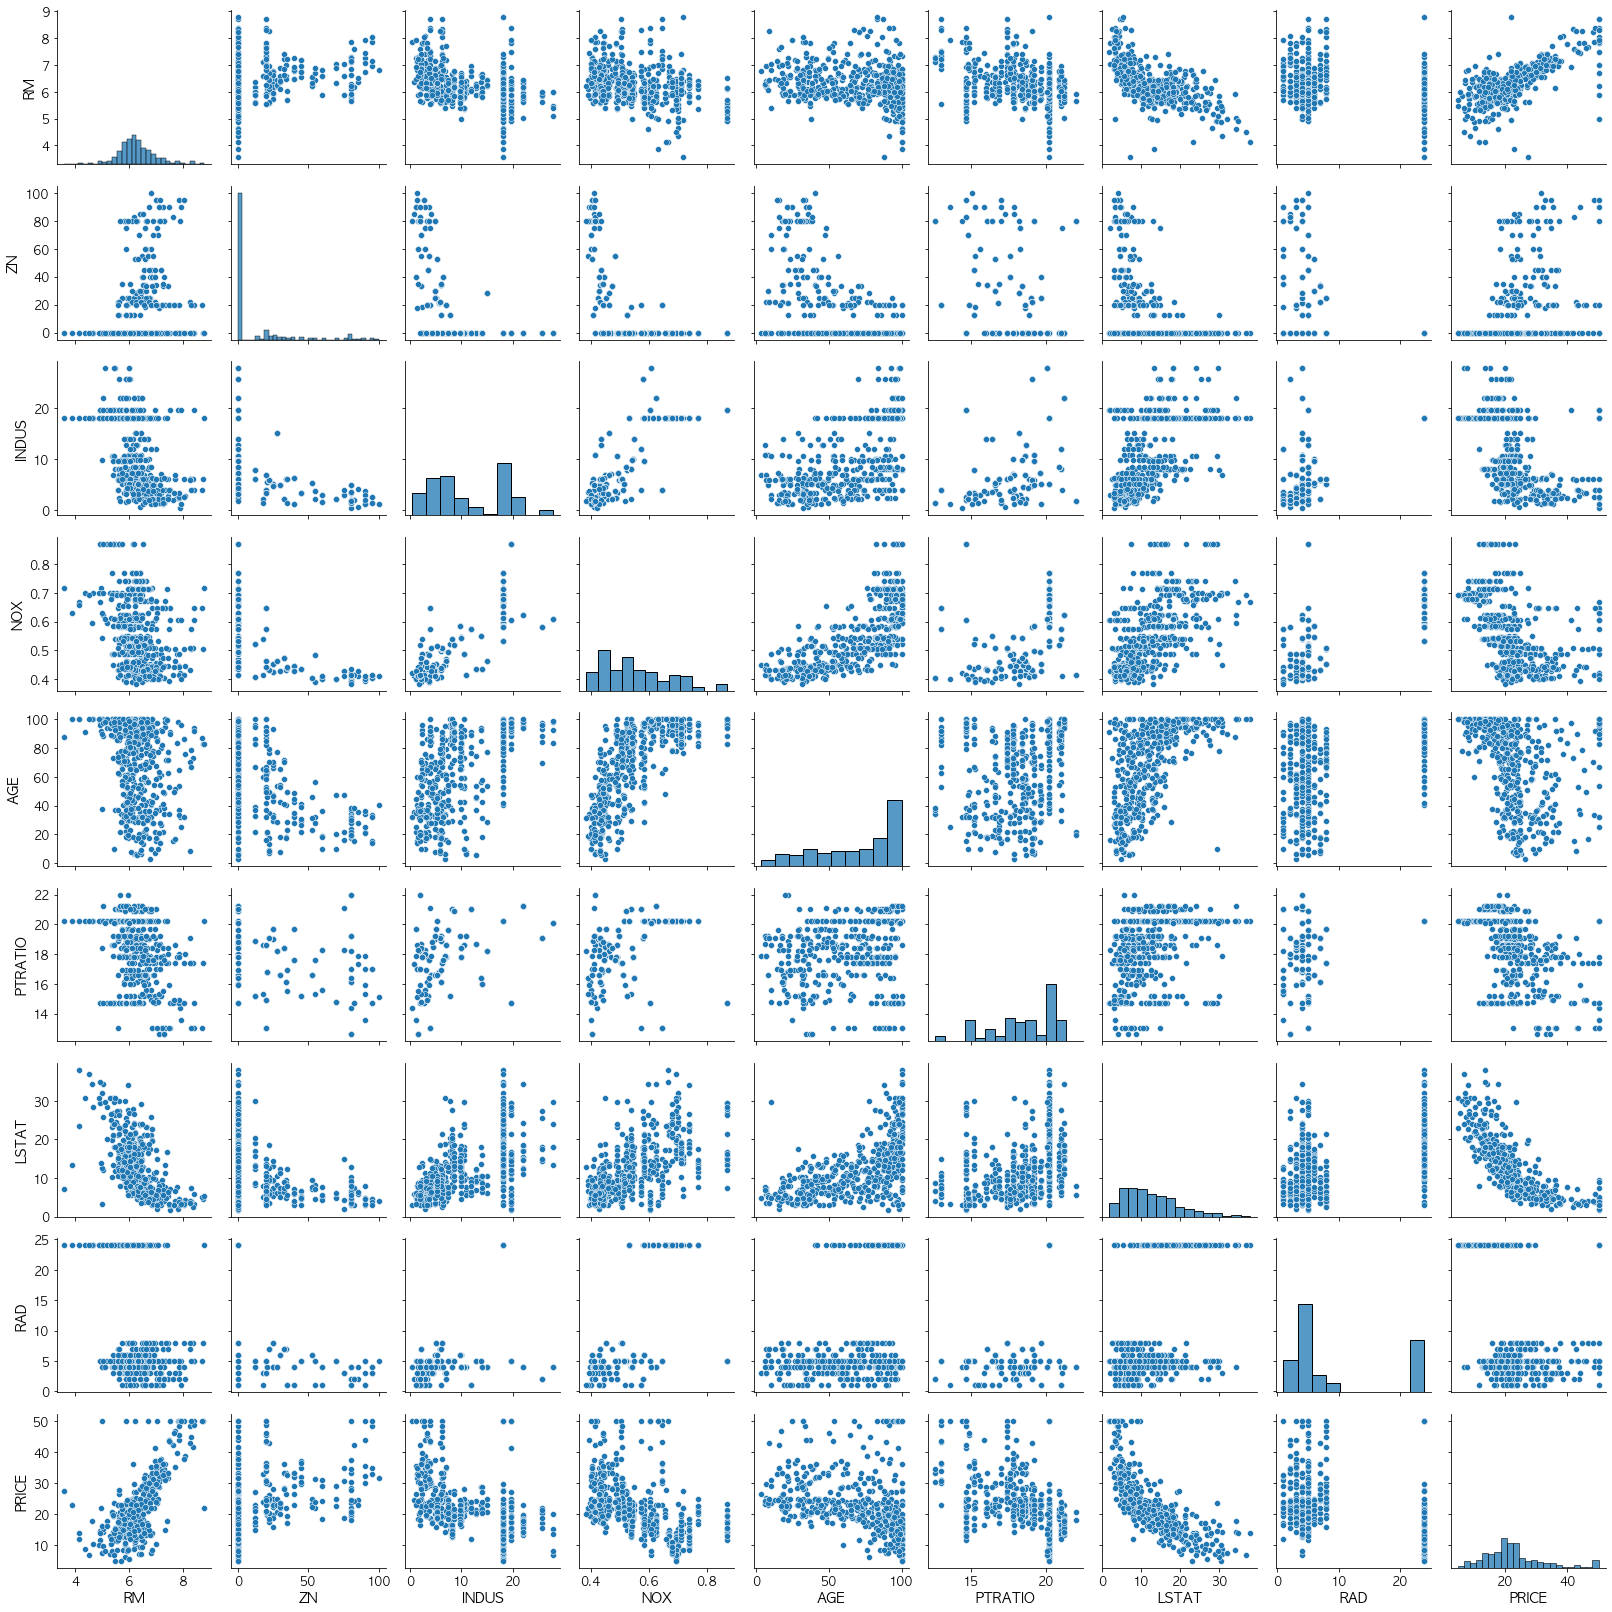

In [18]:
#8개 속성의 선형 관계 파악을 위한 데이터 탐색
cols = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD', 'PRICE']

sns.pairplot(bostonDF[cols], height=2.5)
plt.tight_layout()
plt.show()

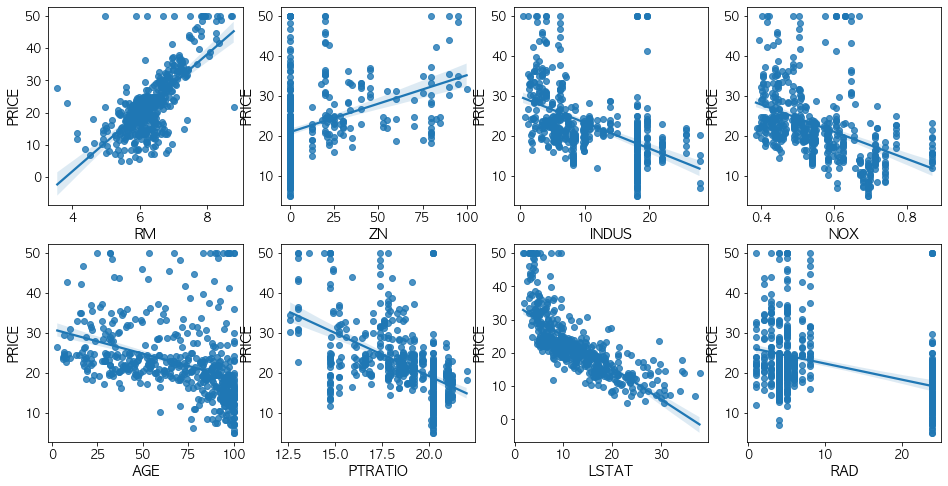

In [19]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

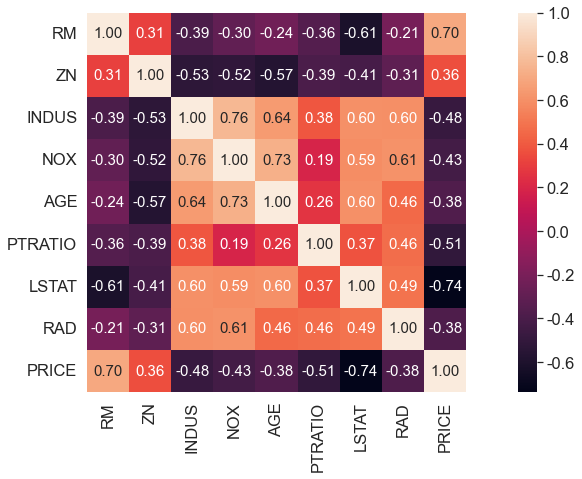

In [20]:
#5개 속성의 상관 계수 확인
import numpy as np
cm = np.corrcoef(bostonDF[cols].values.T)
plt.figure(figsize=(15,7))
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

### scipy 이용한 선형 회귀

In [21]:
from scipy import stats
slope, intercept, r_value, p_value, stderr = stats.linregress(bostonDF['RM'], bostonDF['PRICE'])
print("기울기:", slope)
print("절편:", intercept)
print("상관계수", r_value)
print("불확실성 정도:", p_value)
print("방이 4개일 때 주택 가격:", end=' ')
print((4 * slope + intercept) * 1000, '$')
print('=======================================================')

기울기: 9.102108981180306
절편: -34.67062077643854
상관계수 0.695359947071539
불확실성 정도: 2.487228871008377e-74
방이 4개일 때 주택 가격: 1737.8151482826852 $


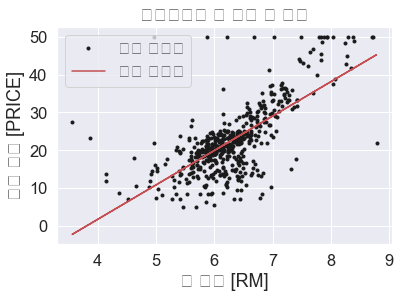

In [22]:
from scipy import polyval
#기존 데이터를 회귀식에 대입해서 list 만들기 
ry = polyval([slope, intercept], bostonDF['RM'])
from pylab import plot, title, show, legend

#실제 데이터를 가지고 산점도 그리기
plot(bostonDF['RM'], bostonDF['PRICE'],'k.')

#회귀분석 결과를 가지고 직선 그래프 그리기
plot(bostonDF['RM'], ry,'r')

title('주택가격과 방 개수 의 관계')
legend(['실제 데이터', '예측 데이터'])
plt.xlabel('방 개수 [RM]')
plt.ylabel('주택 가격 [PRICE]')
show()

### sklearn 을 이용한 선형 회귀

기울기: 9.102
절편: -34.671


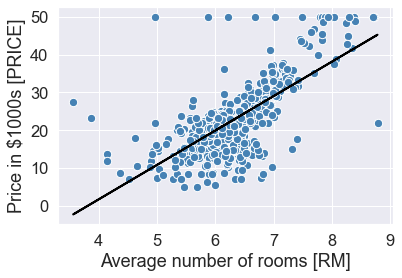

In [23]:
#단병량 회귀 분석 수행
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
X = bostonDF[['RM']].values
y = bostonDF['PRICE'].values
slr.fit(X, y)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

#실제 데이터와 예측 데이터의 그래프 그리기
import matplotlib.pyplot as plt
plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
plt.plot(X, slr.predict(X), color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [PRICE]')

plt.show()

### RANSAC 이용

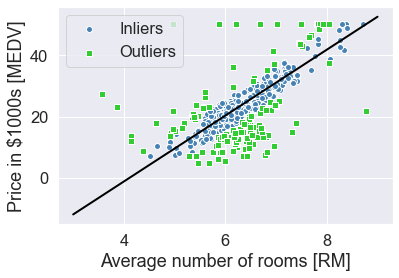

기울기: 10.735
절편: -44.089


In [24]:
from sklearn.linear_model import RANSACRegressor

#RANSAC 알고리즘 수행을 위한 객체 생성
#max_trials는 최대 수행 횟수
#min_samples는 최소 샘플 데이터 개수
#loss는 오차측정 함수를 지정하는 것으로 알고리즘이 학습한 직선과 실제 데이터와의 직선 거리로 설정
#residual_threshold는 잔차의 최대 거리

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)

#선형 회귀분석 수행
ransac.fit(X, y)

#데이터들이 오차 범위 내에 있는지 여부를 저장한 배열을 가져와서 저장
inlier_mask = ransac.inlier_mask_

#배열의 값을 반대로 만들어서 저장
outlier_mask = np.logical_not(inlier_mask)


#그래프를 그릴 범위 설정
line_X = np.arange(3, 10, 1)

#그릴 범위에 해당하는 데이터의 예측값 가져오기
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

#실제 데이터를 산점도로 표현
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
#예측 모델을 선 그래프로 표현
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

### 훈련데이터를 이용한 회귀

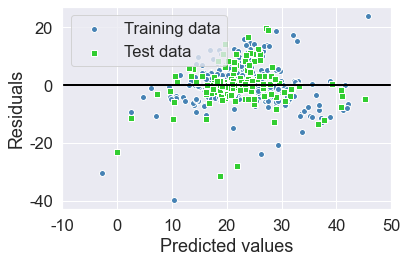

훈련 MSE: 42.158, 테스트 MSE: 47.033
훈련 R^2: 0.503, 테스트 R^2: 0.435


In [25]:
from sklearn.model_selection import train_test_split

#회귀분석 수행
X = bostonDF[['RM']].values
y = bostonDF['PRICE'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()

slr.fit(X_train, y_train)

#분석의 결과로나온 모델을 가지고 훈련 데이터와 검증 데이터의 결과를 생성
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)


#모델에 의해 나온 데이터와 실제 데이터를 산포도로 출력
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

### 다변량 선형 회귀

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행. 
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


In [27]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164336
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [28]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### statsmodels를 이용한 선형 회귀

In [29]:
import pandas as pd
import statsmodels.formula.api as sm
df = pd.read_csv("./data/score.csv", encoding="ms949")

result = sm.ols(formula = 'score ~ iq + academy + game + tv', data = df).fit()

print('절편과 기울기')
print(result.params)
print()
print('유의확률:' , result.pvalues)
print()

print('결정계수:' , result.rsquared)

print('각 학생의 예측 점수:', result.predict())

#IQ가 130이고 학원을 3개 다니고 게임을 2시간하고 TV를 1시간 보는 학생의 예측 점수는?
y = result.params.Intercept + 130*result.params.iq + 3*result.params.academy + 2*result.params.game+1*result.params.tv
print("예측점수:" , y)

절편과 기울기
Intercept    23.299232
iq            0.468422
academy       0.717901
game         -0.838955
tv           -1.385408
dtype: float64

유의확률: Intercept    0.117508
iq           0.003376
academy      0.534402
game         0.131001
tv           0.184269
dtype: float64

결정계수: 0.9608351062148871
각 학생의 예측 점수: [89.47516936 75.89680196 74.68614801 82.68433242 63.58609587 80.84448722
 82.54342107 72.89049111 86.12886227 80.2641907 ]
예측점수: 83.28448678034155


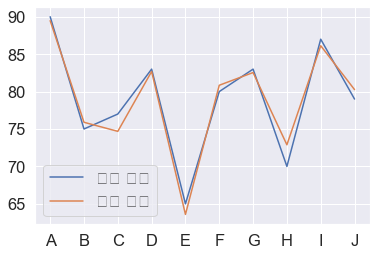

In [30]:
plt.figure()
plt.plot(df['score'], label='실제 성적')
plt.plot(result.predict(), label='예측 성적')
plt.xticks(range(0,10,1),df['name'])
plt.legend();
plt.show()

### 다중 공선성 문제

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(df)

X = df.drop(['score', 'name'], axis = 1)
#print(X)

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))


X = df.drop(['score', 'name', 'academy'], axis = 1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif.round(1))

   VIF Factor features
0        31.2       iq
1        13.4  academy
2         3.1     game
3         7.8       tv
   VIF Factor features
0         3.5       iq
1         2.9     game
2         3.0       tv


## 프로야구 선수 연봉 예측

### 데이터 읽어오기

In [32]:
pitcher_file_path = './data/pitcher_stats_2017.csv'
batter_file_path = './data/batter_stats_2017.csv'
pitcher = pd.read_csv(pitcher_file_path)
batter = pd.read_csv(batter_file_path)

### 데이터 확인

In [33]:
print(pitcher.head())

print(pitcher.columns)

print(pitcher.shape)

   선수명   팀명   승   패  세  홀드  블론  경기  선발     이닝  ...  홈런/9  BABIP  LOB%   ERA  \
0   켈리   SK  16   7  0   0   0  30  30  190.0  ...  0.76  0.342  73.7  3.60   
1   소사   LG  11  11  1   0   0  30  29  185.1  ...  0.53  0.319  67.1  3.88   
2  양현종  KIA  20   6  0   0   0  31  31  193.1  ...  0.79  0.332  72.1  3.44   
3  차우찬   LG  10   7  0   0   0  28  28  175.2  ...  1.02  0.298  75.0  3.43   
4  레일리   롯데  13   7  0   0   0  30  30  187.1  ...  0.91  0.323  74.1  3.80   

   RA9-WAR   FIP  kFIP   WAR  연봉(2018)  연봉(2017)  
0     6.91  3.69  3.44  6.62    140000     85000  
1     6.80  3.52  3.41  6.08    120000     50000  
2     6.54  3.94  3.82  5.64    230000    150000  
3     6.11  4.20  4.03  4.63    100000    100000  
4     6.13  4.36  4.31  4.38    111000     85000  

[5 rows x 22 columns]
Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype

In [34]:
pitcher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

<AxesSubplot:>

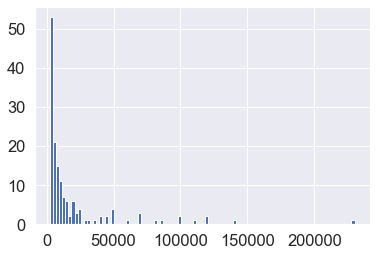

In [35]:
pitcher['연봉(2018)'].hist(bins=100) # 2018년 연봉 분포를 출력합니다.

<AxesSubplot:>

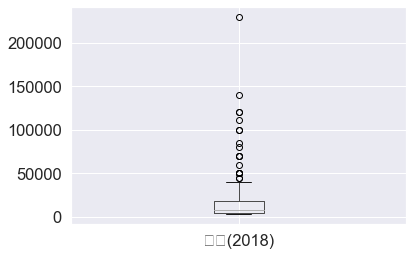

In [36]:
pitcher.boxplot(column=['연봉(2018)']) # 연봉의 Boxplot을 출력합니다.

### 피처 살펴보기

In [37]:
pitcher_features_df = pitcher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)']]

In [38]:
# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

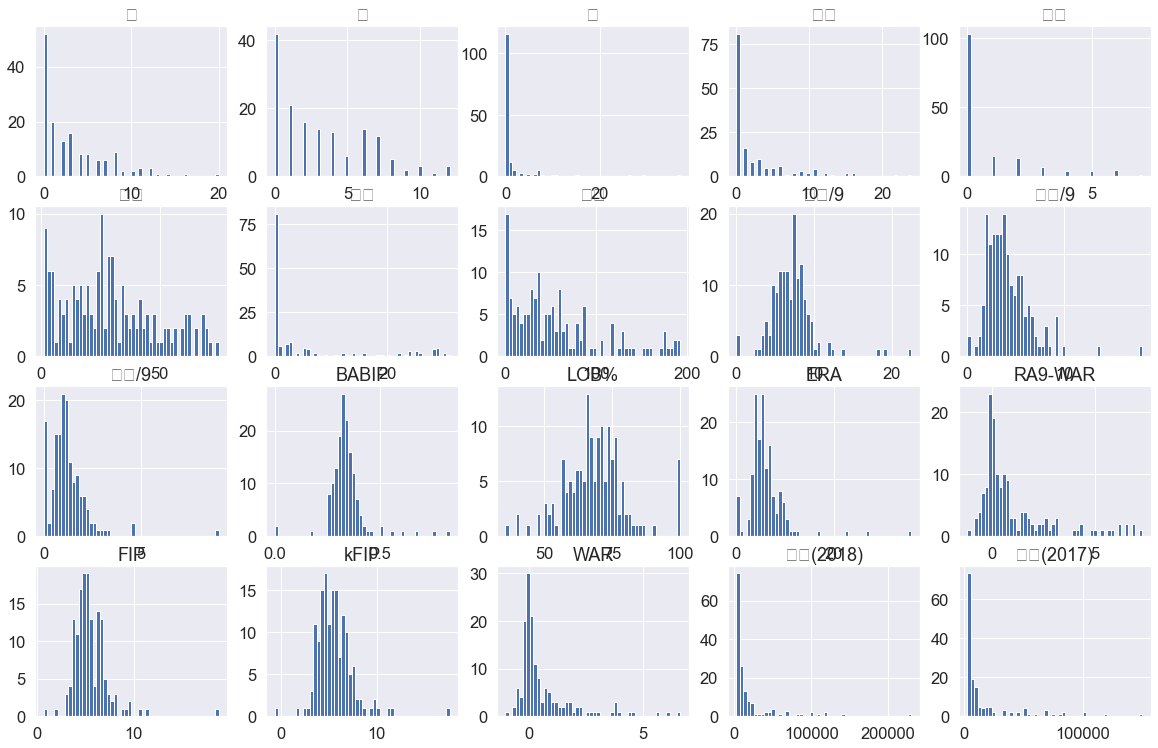

In [39]:
plot_hist_each_column(pitcher_features_df)

### scailing

In [40]:
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [41]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [42]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']
pitcher_df = standard_scaling(pitcher, scale_columns)

In [43]:
pitcher_df = pitcher_df.rename(columns={'연봉(2018)': 'y'})
pitcher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


### one-hot encoding

In [44]:
# 팀명 피처를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(pitcher_df['팀명'])
pitcher_df = pitcher_df.drop('팀명', axis=1)
pitcher_df = pitcher_df.join(team_encoding)

team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [45]:
pitcher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


### 회귀 분석

In [46]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리합니다.
X = pitcher_df[pitcher_df.columns.difference(['선수명', 'y'])]
y = pitcher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 학습된 계수를 출력합니다.
print(lr.coef_)

[ -1863.27167152   1147.15608757 -52147.32574794   5915.51391759
   2299.44885884  -1744.6150334     397.17996335   -249.60365919
  -1024.27838506    399.1396206   12274.79760529  44088.31585257
  -3602.91866901  -5319.02202278    617.34035282   4644.19380296
    879.30541662  -3936.74747195   1521.68382584 -10999.04385918
   -700.8303505    4526.7078132   21785.5776696    6965.59101874
    154.91380911   2018.54543747  -1217.59759673   9090.86143072]


In [47]:
pitcher_df.columns

Index(['선수명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9',
       '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', 'y',
       '연봉(2017)', 'KIA', 'KT', 'LG', 'NC', 'SK', '두산', '롯데', '삼성', '한화'],
      dtype='object')

### 예측 모델 평가

In [48]:
#분석의 결과로나온 모델을 가지고 훈련 데이터와 검증 데이터의 결과를 생성
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 RMSE: %.3f, 테스트 RMSE: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 74824945.366, 테스트 MSE: 81760179.592
훈련 RMSE: 8650.141, 테스트 RMSE: 9042.134
훈련 R^2: 0.932, 테스트 R^2: 0.755


### 상관 관계 파악

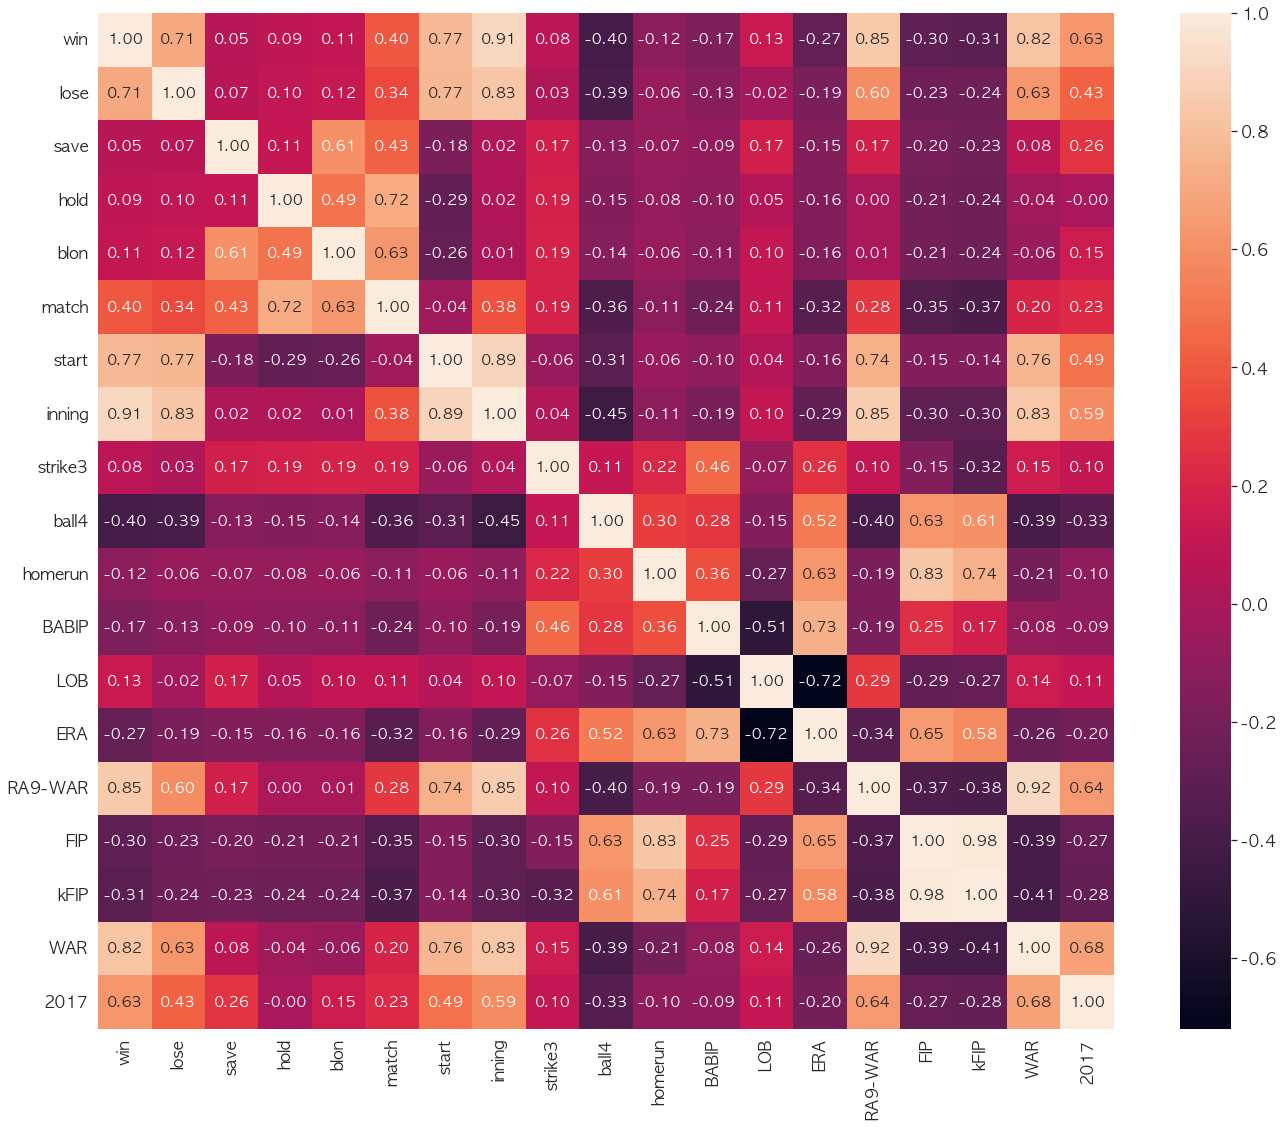

In [49]:
# 피처간의 상관계수 행렬을 계산합니다.
corr = pitcher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

#매킨토시의 경우
if platform.system() == 'Darwin':
    fontname = "AppleGothic"
else:
    fontname = "Malgun Gothic"

# corr 행렬 히트맵을 시각화합니다.
sns.set(font=fontname, 
        rc={"axes.unicode_minus":False},
        style='darkgrid',
        font_scale=1.5)

hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


### 피처를 재선정 한 후 수행

In [51]:
# 피처를 재선정합니다.
X = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = pitcher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# 결과를 출력합니다.
print(model.score(X_train, y_train)) # train R2 score를 출력합니다.
print(model.score(X_test, y_test)) # test R2 score를 출력합니다.

0.9150591192570362
0.9038759653889864


In [52]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions))) # test RMSE score를 출력합니다.

7893.462873347692
13141.866063591087


In [53]:
# 피처마다의 VIF 계수를 출력합니다.
X = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


### 분석 결과 시각화

In [54]:
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성합니다.
X = pitcher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
pitcher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)

# 원래의 데이터 프레임을 다시 로드합니다.
pitcher = pd.read_csv(pitcher_file_path)
pitcher = pitcher[['선수명', '연봉(2017)']]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = pitcher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(pitcher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


<AxesSubplot:xlabel='선수명'>

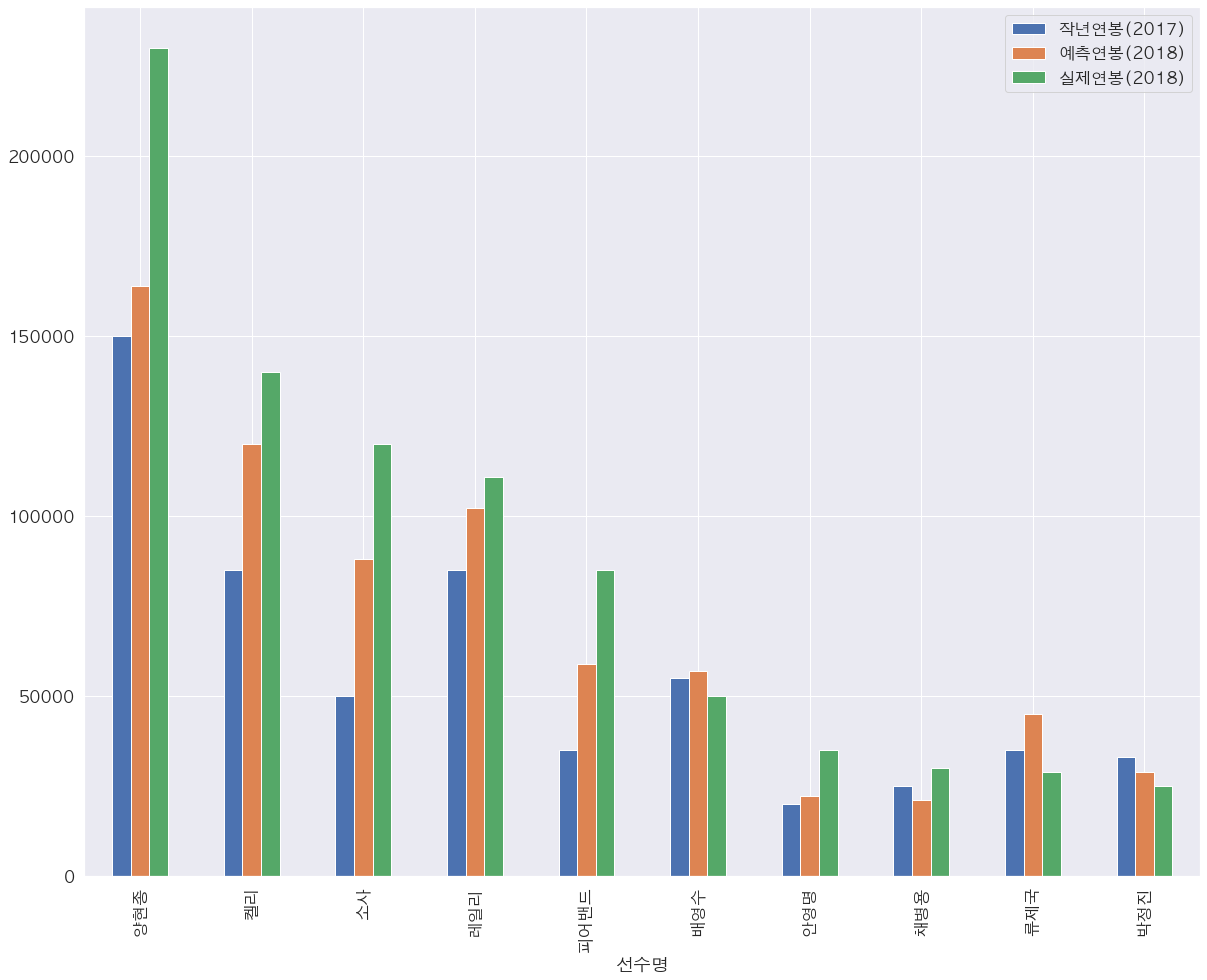

In [55]:
# 선수별 연봉 정보(작년 연봉, 예측 연봉, 실제 연봉)를 bar 그래프로 출력합니다.
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind="bar")

## 다항 회귀

### 다항식 변환

In [56]:
from sklearn.preprocessing import PolynomialFeatures

# 다항식으로 변환한 단항식 생성, [[0,1],[2,3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n',X )

# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 feature:\n', poly_ftr)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [57]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    print(X[:, 0])
    print(X[:, 1])
    return y

X = np.arange(0,4).reshape(2,2)

print('일차 단항식 계수 feature: \n' ,X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

# 3 차 다항식 변환 
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n',poly_ftr)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
[0 2]
[1 3]
삼차 다항식 결정값: 
 [  5 125]
3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]


### 다항 회귀

그림 저장: quadratic_data_plot


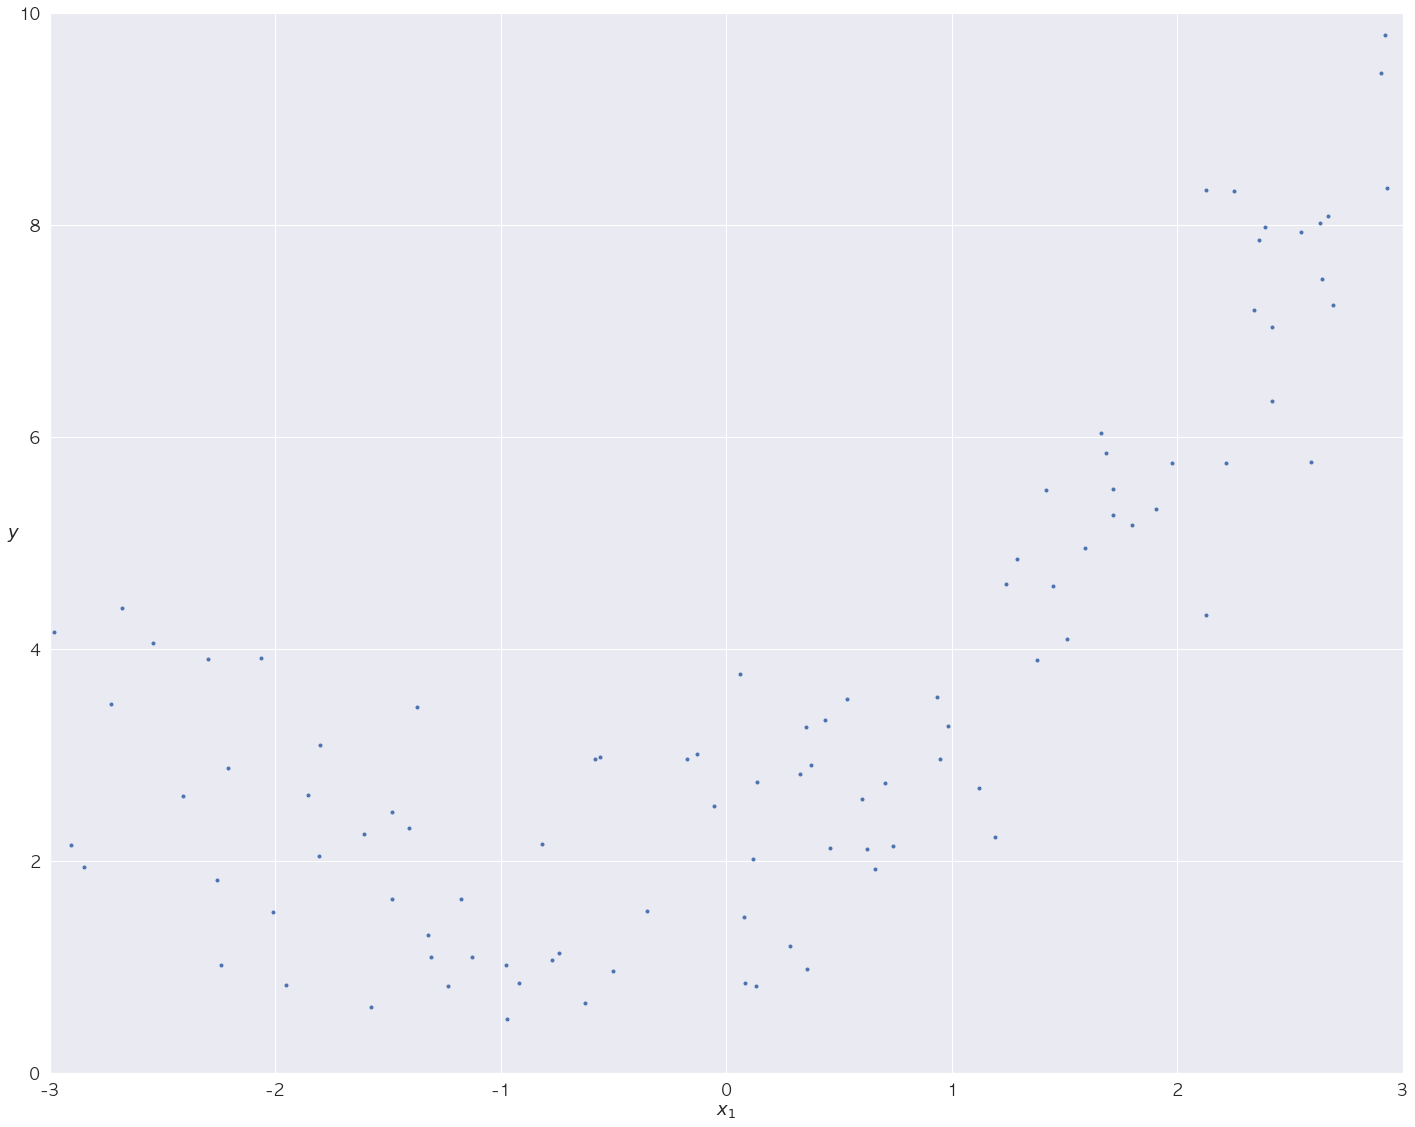

In [58]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [59]:
from sklearn.preprocessing import PolynomialFeatures
#추가할 다항식 - degree는 차수, include_bias는 편향을 위한 상수 추가 옵션
poly_features = PolynomialFeatures(degree=2, include_bias=False)
#제곱을 추가한 데이터
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.38942838]
[2.38942838 5.709368  ]


In [60]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

그림 저장: quadratic_predictions_plot


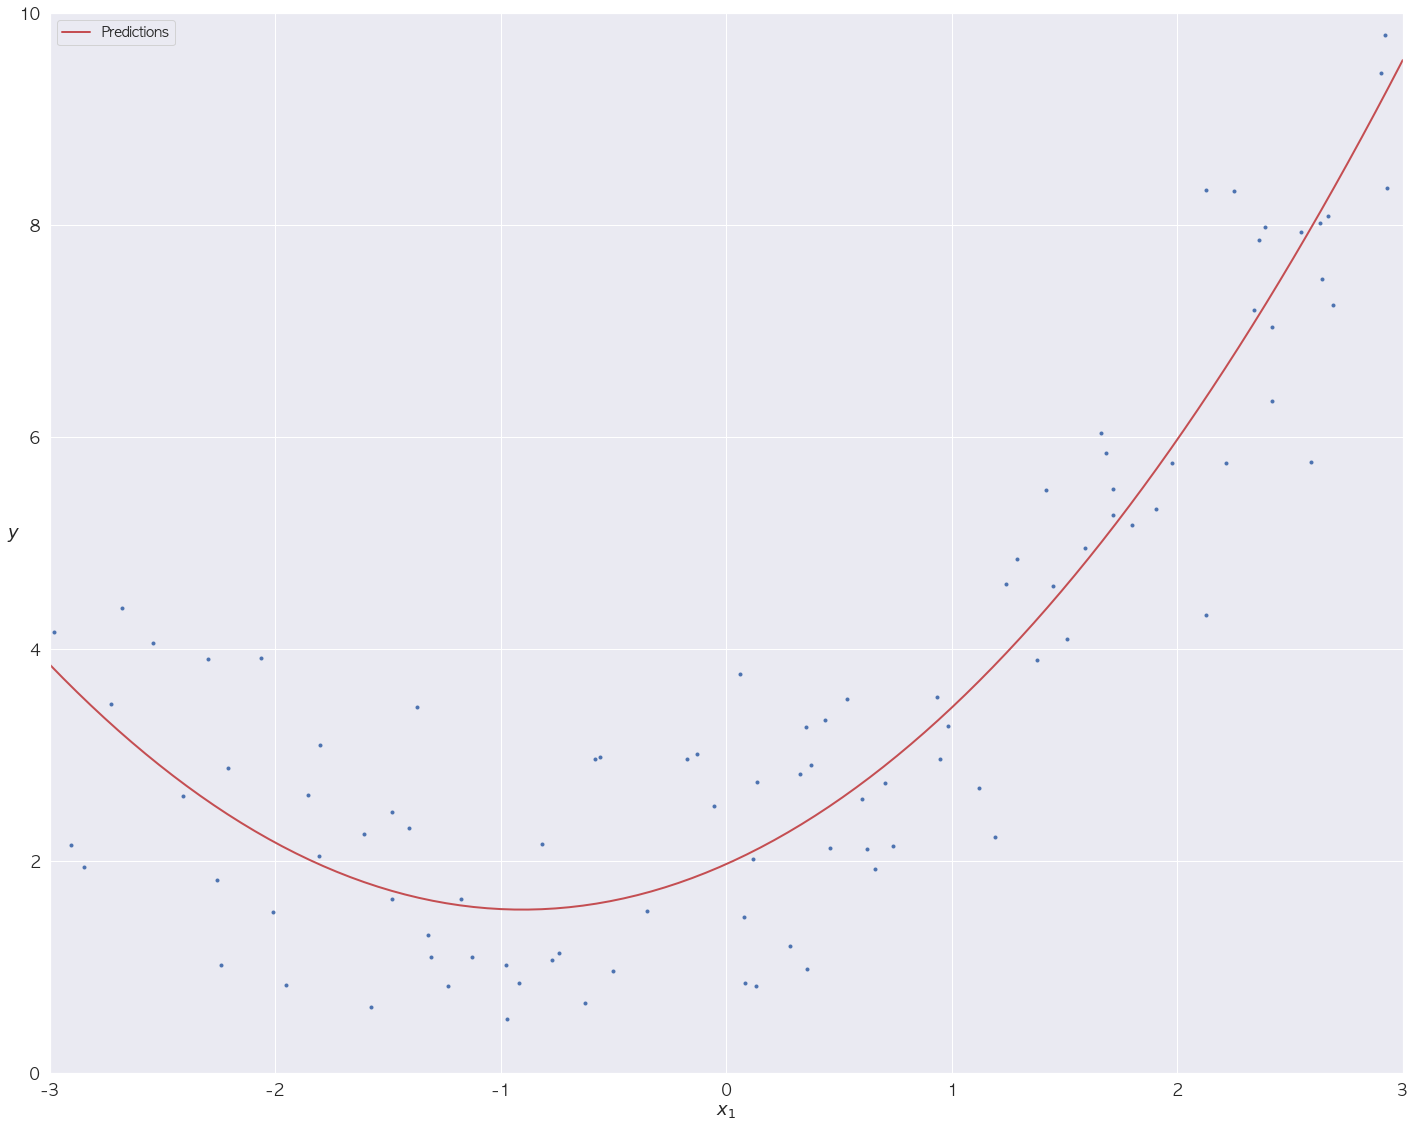

In [61]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

### 다항 회귀 모델 비교

그림 저장: high_degree_polynomials_plot


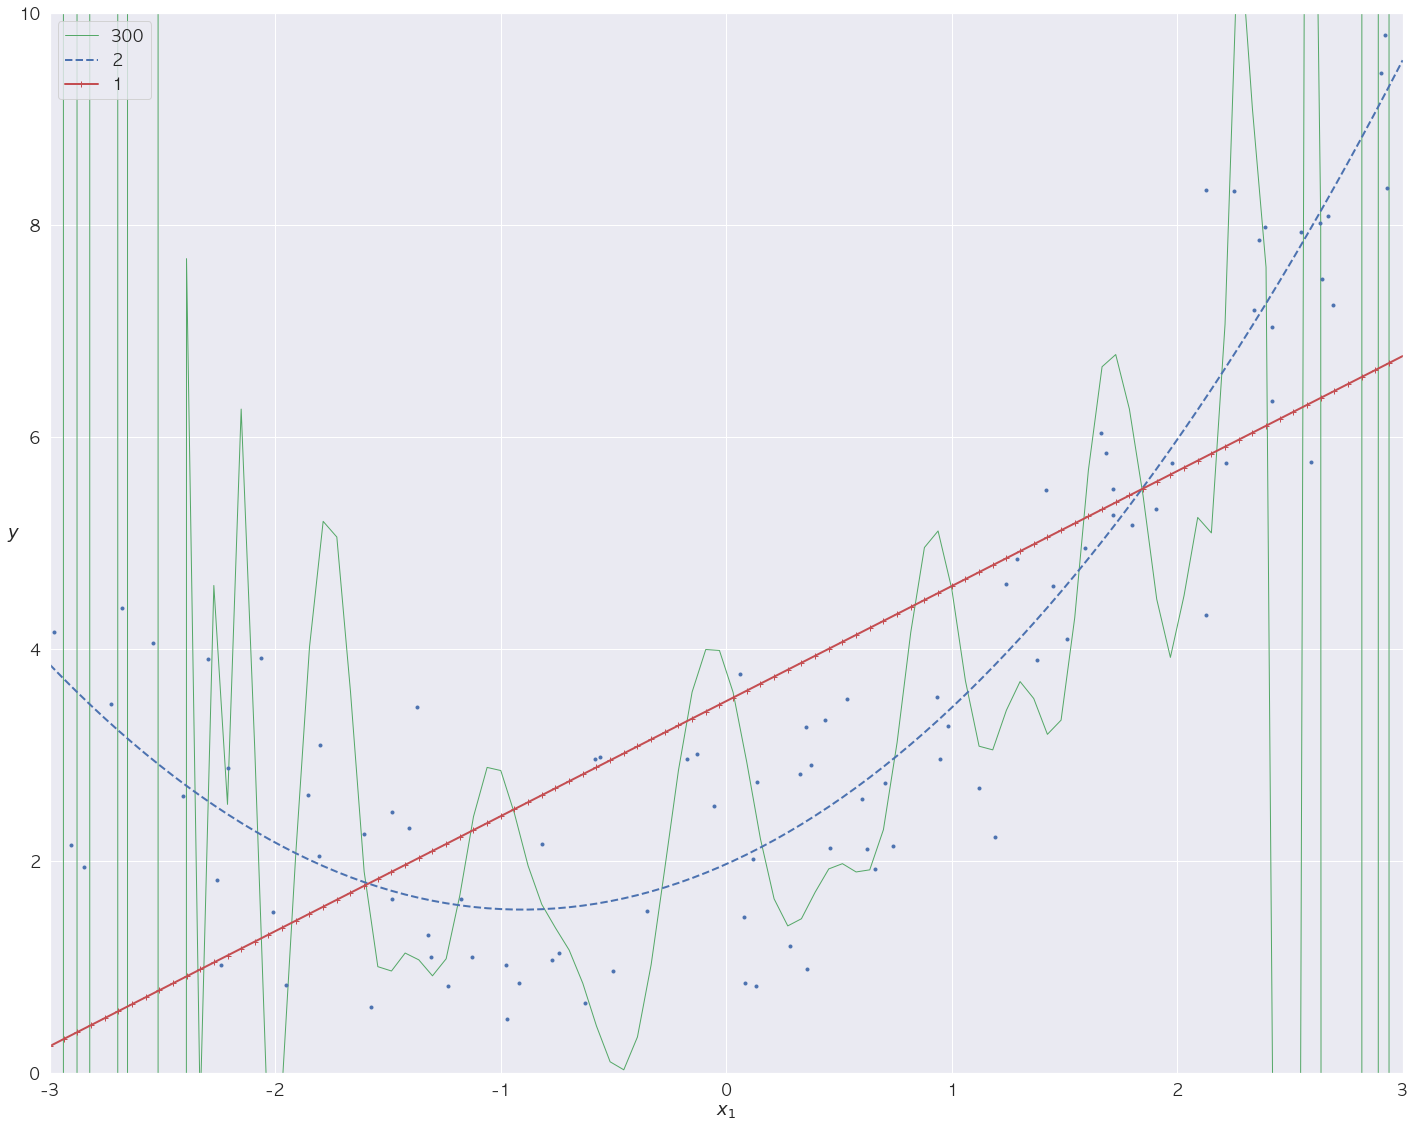

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

## 학습 곡선 확인

### 단순 선형 회귀 모델

그림 저장: underfitting_learning_curves_plot


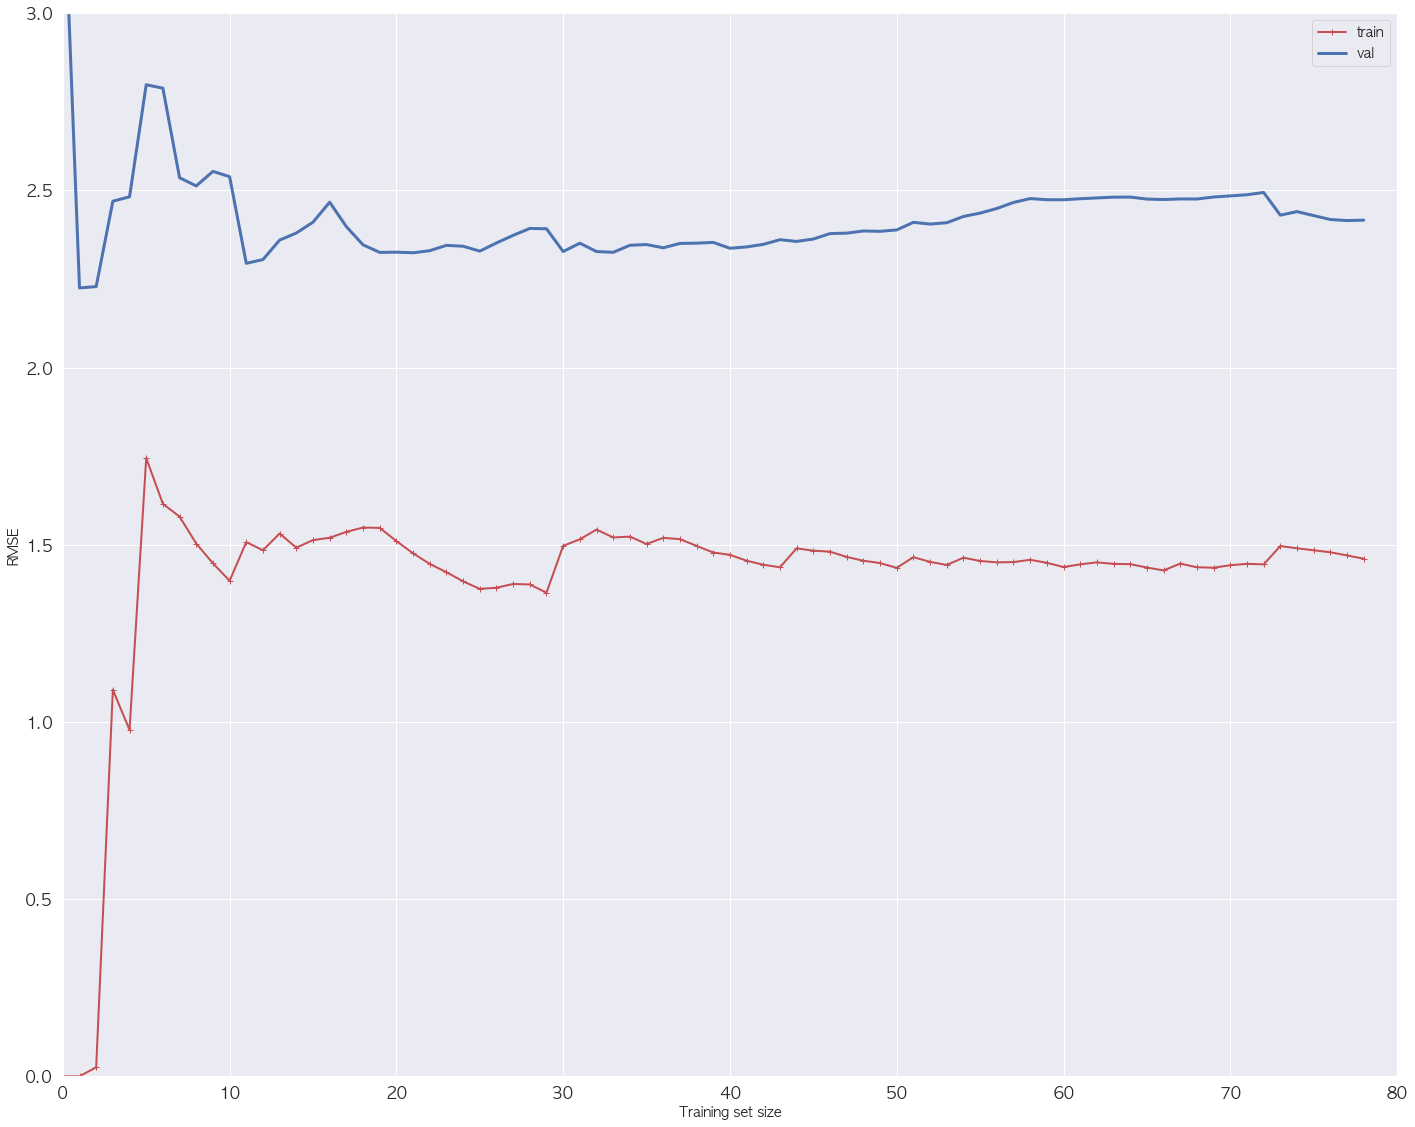

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              
    lin_reg = LinearRegression()
    
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
save_fig("underfitting_learning_curves_plot")   
plt.show()                                      

### 10차 다항 회귀 모델

그림 저장: learning_curves_plot


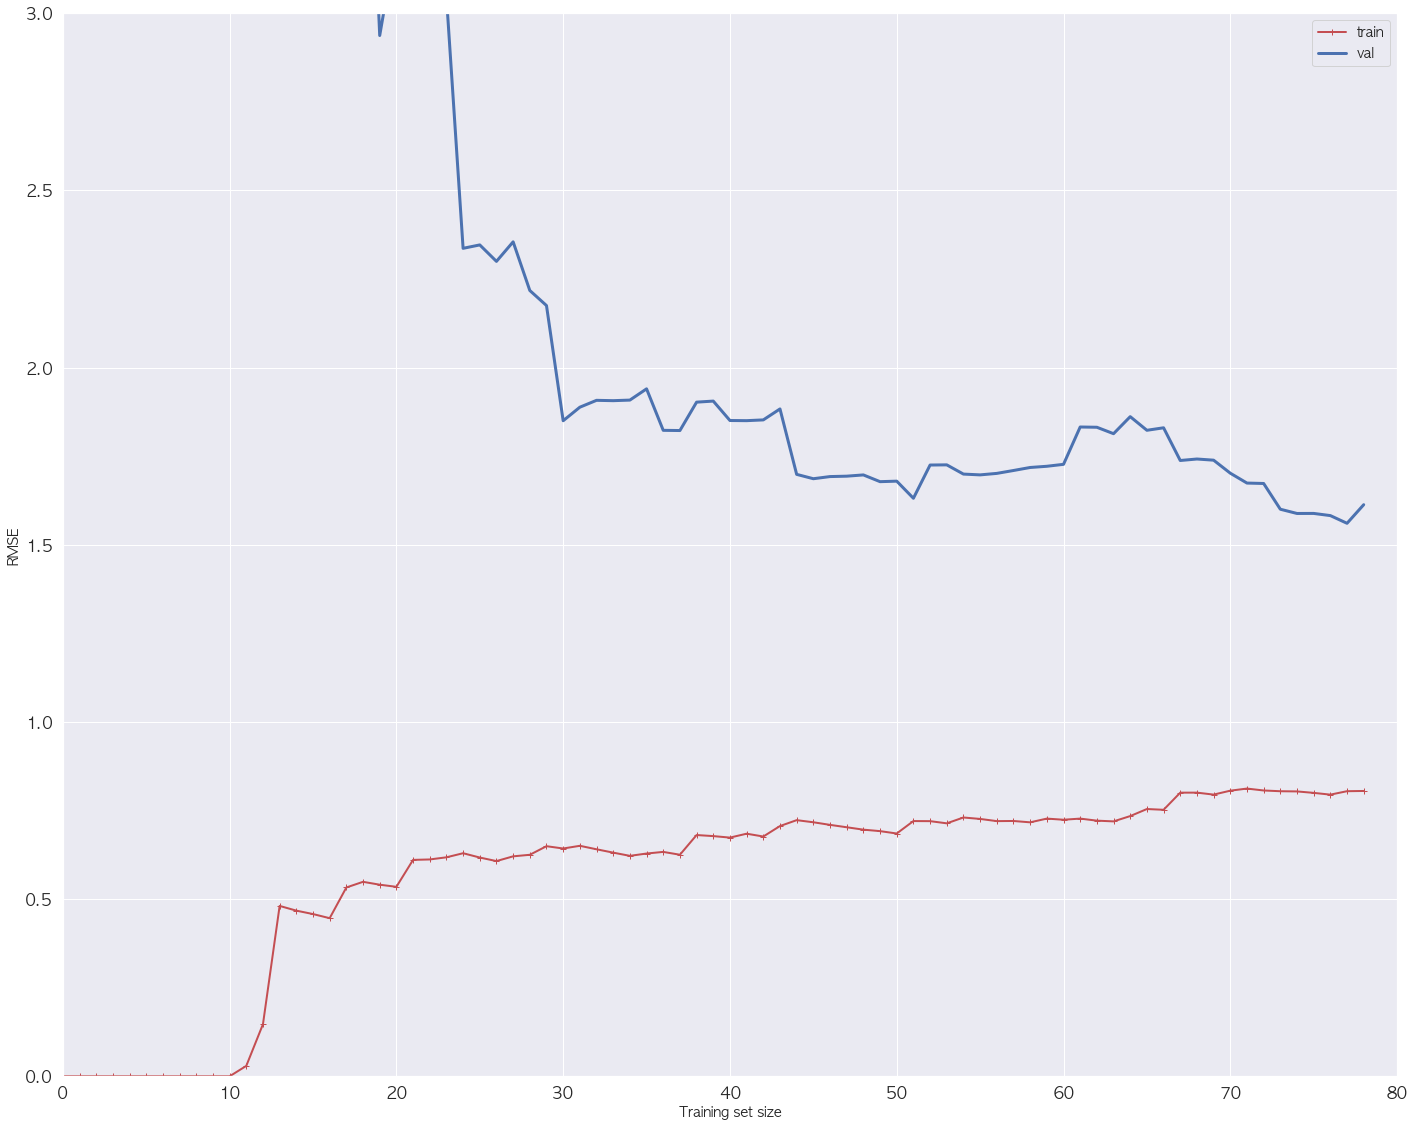

In [64]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음

## 규제가 있는 모델

In [65]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### 릿지 회귀

In [66]:
from sklearn.linear_model import Ridge
#경사 하강법 이용 - cholesky를 solve 에 설정하면 행렬 분해를 이용
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
print(ridge_reg.predict([[1.5]]))

neg_mse_scores = cross_val_score(ridge_reg, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

[[1.5507201]]
 5 folds 의 개별 Negative MSE scores:  [-13.992 -30.186 -37.69  -46.601 -21.083]
 5 folds 의 개별 RMSE scores :  [3.741 5.494 6.139 6.827 4.592]
 5 folds 의 평균 RMSE : 5.358 


그림 저장: ridge_regression_plot


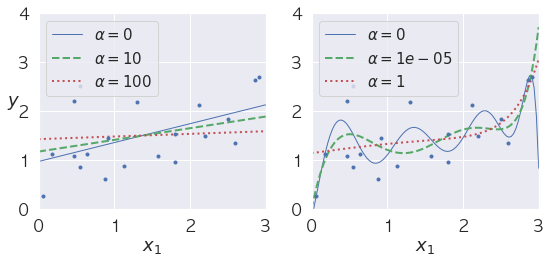

In [67]:
#학습률에 따른 회귀 계수의 변화
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

### 보스턴 주택 셋에 릿지 회귀 적용

In [68]:
# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

# Ridge에 사용될 alpha 파라미터의 값들을 정의
alphas = [0 , 0.1 , 1 , 10 , 100]

# alphas list 값을 iteration하면서 alpha에 따른 평균 rmse 구함.
for alpha in alphas :
    ridge = Ridge(alpha = alpha)
    
    #cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

Boston 데이타셋 크기 : (506, 14)
alpha 0 일 때 5 folds 의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330 


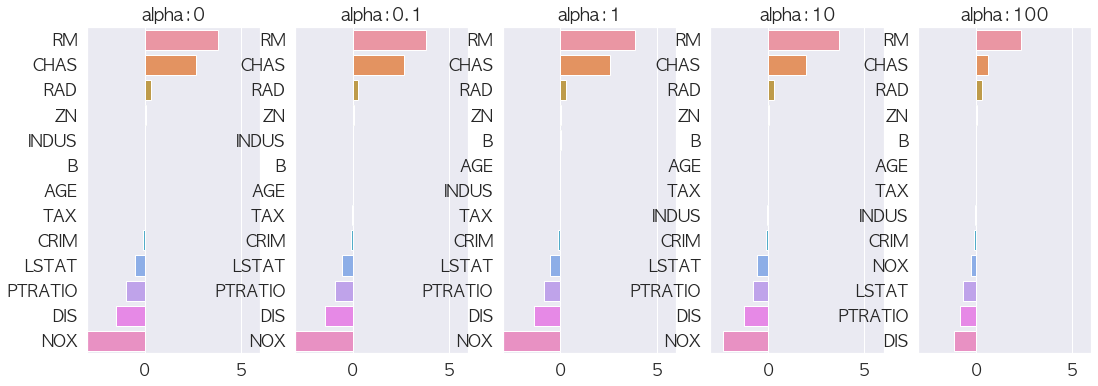

In [69]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성  
fig , axs = plt.subplots(figsize=(18,6) , nrows=1 , ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data , y_target)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coeff = pd.Series(data=ridge.coef_ , index=X_data.columns )
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values , y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()



In [70]:
ridge_alphas = [0 , 0.1 , 1 , 10 , 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### 라쏘 회귀

In [71]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

그림 저장: lasso_regression_plot


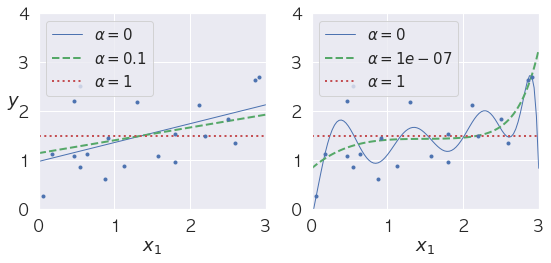

In [72]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

### 보스턴 주택 셋에 라쏘 적용

In [73]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, 
                        verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('####### ', model_name , '#######')
    for param in params:
        if model_name =='Ridge': model = Ridge(alpha=param)
        elif model_name =='Lasso': model = Lasso(alpha=param)
        elif model_name =='ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, 
                                             y_target_n, scoring="neg_mean_squared_error", cv = 5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f} '.format(param, avg_rmse))
        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        
        model.fit(X_data_n , y_target_n)
        if return_coeff:
            # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가. 
            coeff = pd.Series(data=model.coef_ , index=X_data_n.columns )
            colname='alpha:'+str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

# 라쏘에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df =get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189 


In [74]:
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


### 릿지 와 라쏘

그림 저장: lasso_vs_ridge_plot


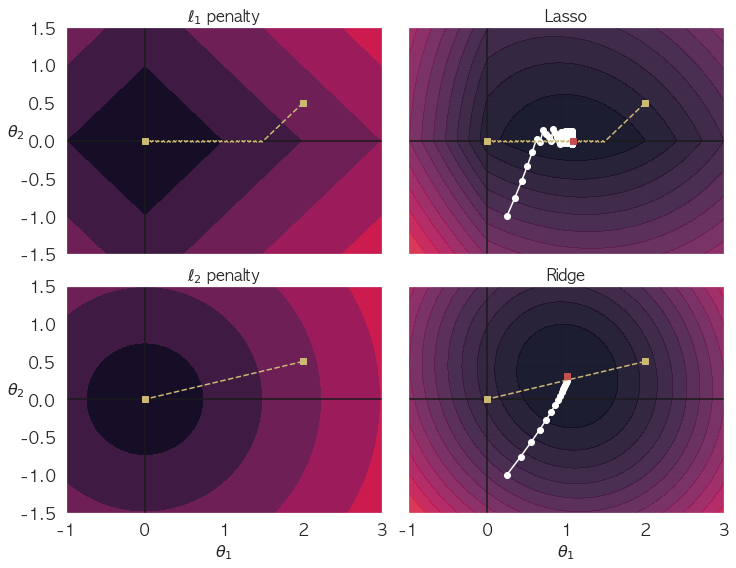

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

### 엘라스틱 넷

In [76]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 보스턴 데이터 셋에 엘라스틱 넷 적용

In [77]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df =get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                      X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068 


In [78]:
# 반환된 coeff_elastic_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


## 조기 종료

그림 저장: early_stopping_plot


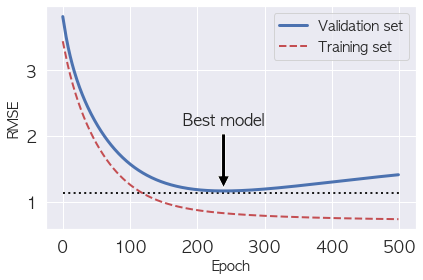

In [79]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
        
        
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [80]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

### 스케일링

In [81]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출. 
alphas = [0.1, 1, 10, 100]
#변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환 
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)

(506, 13) (506, 13)

## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330 
(506, 13) (506, 13)

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421 
(506, 104) (506, 13)

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634 
(506, 13) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465 
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754 
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635 
(506, 104) (506, 13)

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298 
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323 
alpha 10일 때 5 폴드 세트의 평균 RMS

## 선형 회귀를 이용한 영화 평점 예측

### 데이터 가져오기

In [82]:
rating_file_path = "./data/ratings.dat"
movie_file_path = "./data/movies.dat"
user_file_path = "./data/users.dat"

rating_data = pd.io.parsers.read_csv(rating_file_path, 
                                     names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::')
movie_data = pd.io.parsers.read_csv(movie_file_path, 
                                    names=['movie_id', 'title', 'genre'], delimiter='::')

user_data = pd.io.parsers.read_csv(user_file_path, 
                                   names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::')

### 데이터 탐색

In [83]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [84]:
movie_data.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [85]:
user_data.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [86]:
#null 개수 파악
print(rating_data.isnull().sum())
print(movie_data.isnull().sum())
print(user_data.isnull().sum())

user_id     0
movie_id    0
rating      0
time        0
dtype: int64
movie_id    0
title       0
genre       0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zipcode       0
dtype: int64


In [87]:
# 총 영화의 개수를 출력합니다.
print("total number of movie in data :", len(movie_data['movie_id'].unique()))

# 연도별 영화 개수가 많은 Top 10 년도를 출력합니다.
movie_data['year'] = movie_data['title'].apply(lambda x: x[-5:-1])
movie_data['year'].value_counts().head(10)

total number of movie in data : 3883


1996    345
1995    342
1998    337
1997    315
1999    283
1994    257
1993    165
2000    156
1986    104
1992    102
Name: year, dtype: int64

In [88]:
# 연대별 영화의 개수를 출력합니다.
movie_data['year_term'] = movie_data['title'].apply(lambda x: x[-5:-2]+"0")
moview_year_term = movie_data['year_term'].value_counts().sort_index()
print(moview_year_term)

1910       3
1920      34
1930      77
1940     126
1950     168
1960     191
1970     247
1980     598
1990    2283
2000     156
Name: year_term, dtype: int64


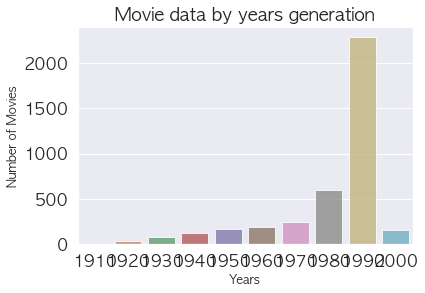

In [89]:
sns.barplot(moview_year_term.index, moview_year_term.values, alpha=0.8)
plt.title('Movie data by years generation')
plt.ylabel('Number of Movies', fontsize=12)
plt.xlabel('Years', fontsize=12)
plt.show()

In [90]:
# 가장 많이 사용된 장르의 조합을 출력합니다. (Top 10)
movie_data['genre'].value_counts()[:10]

Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: genre, dtype: int64

In [91]:
# 가장 많이 등장한 장르의 속성을 추출합니다.
unique_genre_dict = {}
for index, row in movie_data.iterrows():
    
    # genre 피처를 ‘|’ 구분자로 분리합니다.
    genre_combination = row['genre']
    parsed_genre = genre_combination.split("|")
    
    # 구분자로 분리한 장르의 속성을 unique_genre_dict에 각각 계산하여 저장합니다.
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1
            
print(unique_genre_dict)

{'Animation': 105, "Children's": 251, 'Comedy': 1200, 'Adventure': 283, 'Fantasy': 68, 'Romance': 471, 'Drama': 1603, 'Action': 503, 'Crime': 211, 'Thriller': 492, 'Horror': 343, 'Sci-Fi': 276, 'Documentary': 127, 'War': 143, 'Musical': 114, 'Mystery': 106, 'Film-Noir': 44, 'Western': 68}


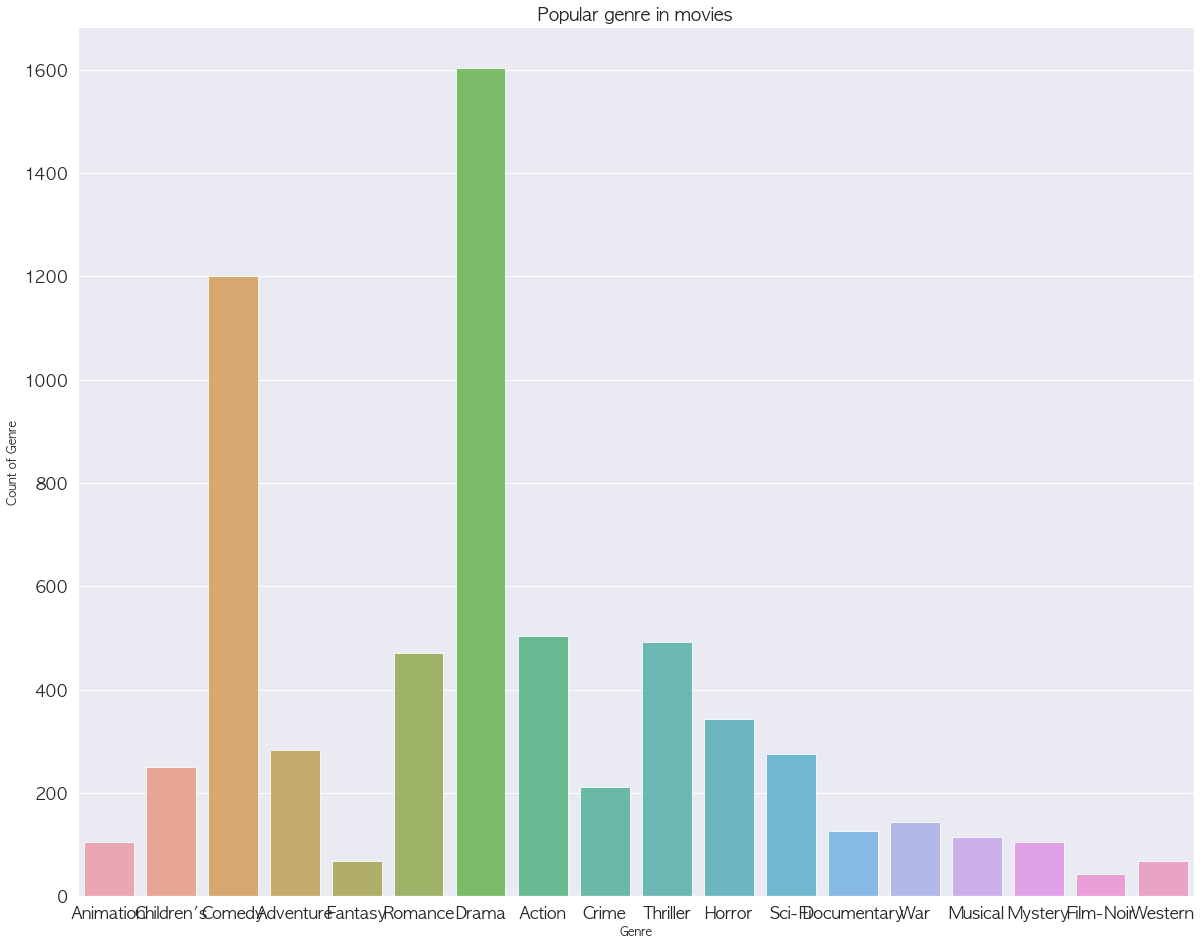

In [92]:
# unique_genre_dict를 이용하여 장르의 속성을 그래프로 출력합니다.
plt.rcParams['figure.figsize'] = [20, 16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()), alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of Genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

In [93]:
# 유저의 수를 탐색합니다.
print("total number of user in data :", len(user_data['user_id'].unique()))

total number of user in data : 6040


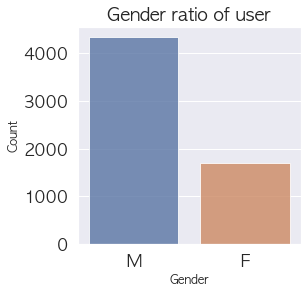

In [94]:
# 유저의 성별을 탐색합니다.
plt.rcParams['figure.figsize'] = [4, 4]
user_gender = user_data['gender'].value_counts()
sns.barplot(user_gender.index, user_gender.values, alpha=0.8)
plt.title('Gender ratio of user')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

In [95]:
# 유저의 연령대를 탐색합니다.
user_data['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [96]:
def age_classification(age):
    if age == 1:
        return 'outlier'
    else:
        return str(age)[0] + "0"

user_data['ages'] = user_data['age'].apply(lambda x: age_classification(x))
user_ages = user_data['ages'].value_counts()

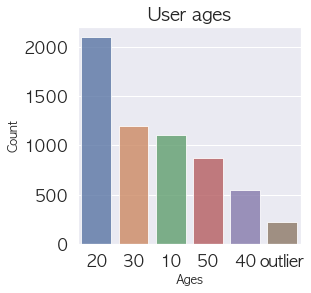

In [97]:
sns.barplot(user_ages.index, user_ages.values, alpha=0.8)
plt.title('User ages')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ages', fontsize=12)
plt.show()

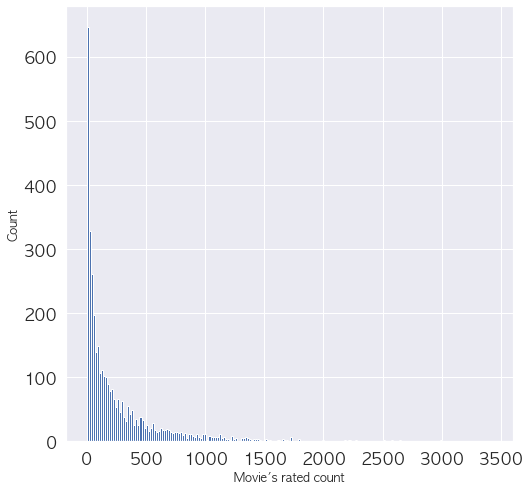

In [98]:
# 각 영화들이 평가받은 횟수를 탐색합니다.
movie_rate_count = rating_data.groupby('movie_id')['rating'].count().values
plt.rcParams['figure.figsize'] = [8, 8]
fig = plt.hist(movie_rate_count, bins=200)
plt.ylabel('Count', fontsize=12)
plt.xlabel("Movie's rated count", fontsize=12)
plt.show()

In [99]:
print("total number of movie in data :", len(movie_data['movie_id'].unique()))
print("total number of movie rated below 100 :", len(movie_rate_count[movie_rate_count < 100]))

total number of movie in data : 3883
total number of movie rated below 100 : 1687


In [100]:
# 영화별 평균 평점을 탐색합니다.
movie_grouped_rating_info = rating_data.groupby("movie_id")['rating'].agg(['count','mean'])
movie_grouped_rating_info.columns = ['rated_count', 'rating_mean']

In [101]:
movie_grouped_rating_info.head(5)

,rated_count,rating_mean
movie_id,,
1,2077,4.146846
2,701,3.201141
3,478,3.016736
4,170,2.729412
5,296,3.006757


<AxesSubplot:>

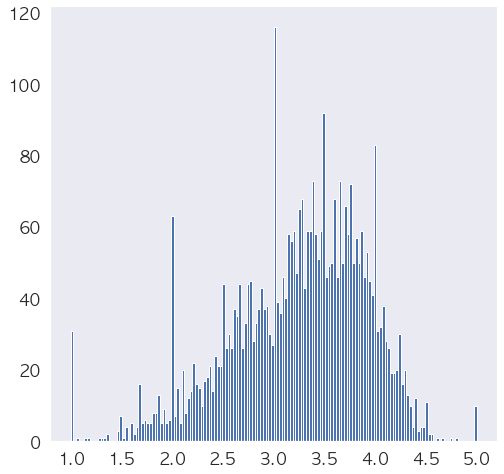

In [102]:
movie_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

In [103]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
merged_data = movie_grouped_rating_info.merge(movie_data, on=['movie_id'], how='left')
merged_data[merged_data['rated_count'] > 100][['rating_mean', 'title']].nlargest(10, 'rating_mean')

,rating_mean,title
1839,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
309,4.554558,"Shawshank Redemption, The (1994)"
802,4.524966,"Godfather, The (1972)"
708,4.520548,"Close Shave, A (1995)"
49,4.517106,"Usual Suspects, The (1995)"
513,4.510417,Schindler's List (1993)
1066,4.507937,"Wrong Trousers, The (1993)"
861,4.491489,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
1108,4.477725,Raiders of the Lost Ark (1981)
843,4.476190,Rear Window (1954)


In [104]:
# 유저별 영화 평가를 탐색합니다.
user_grouped_rating_info = rating_data.groupby('user_id')['rating'].agg(['count','mean', 'std'])
user_grouped_rating_info.columns = ['rated_count', 'rating_mean', 'rating_std']

In [105]:
user_grouped_rating_info.head()

,rated_count,rating_mean,rating_std
user_id,,,
1,53,4.188679,0.680967
2,129,3.713178,1.001513
3,51,3.901961,0.984985
4,21,4.190476,1.077917
5,198,3.146465,1.132699


<AxesSubplot:>

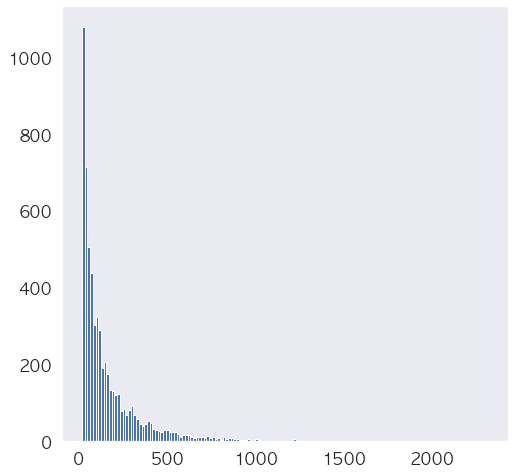

In [106]:
# 유저별로 평가한 영화 개수의 분포를 출력합니다.
user_grouped_rating_info['rated_count'].hist(bins=150, grid=False)

<AxesSubplot:>

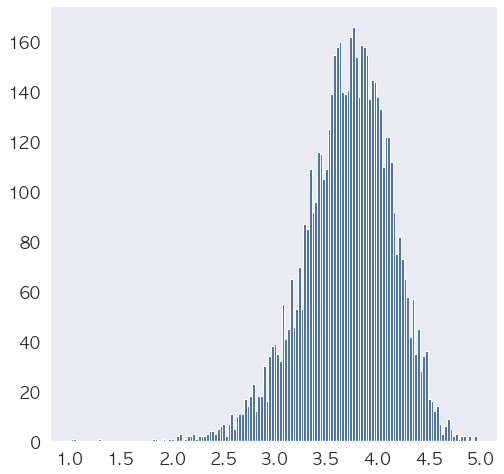

In [107]:
# 유저별로 평가한 영화 점수 평균의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_mean'].hist(bins=150, grid=False)

<AxesSubplot:>

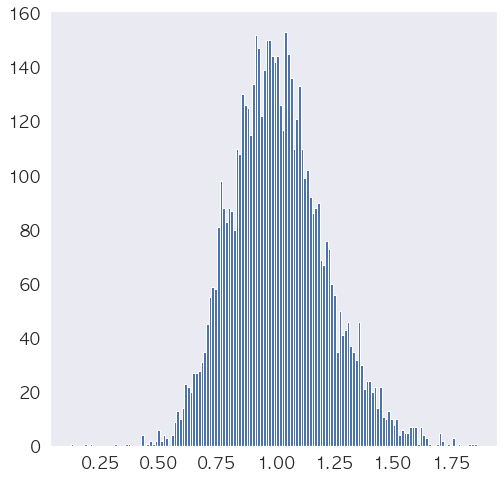

In [108]:
# 유저별로 평가한 영화 점수 편차의 분포를 그래프로 출력합니다.
user_grouped_rating_info['rating_std'].hist(bins=150, grid=False)

In [109]:
rating_data.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [110]:
# unstack() 함수로 user_id, movie_id를 축으로 하는 데이터를 생성합니다.
rating_table = rating_data[['user_id', 'movie_id', 'rating']].set_index(["user_id", "movie_id"]).unstack()
rating_table.head(10)

rating                                               ...            \
movie_id   1    2    3    4    5    6    7    8    9    10    ... 3943 3944   
user_id                                                       ...             
1           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4           NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
5           NaN  NaN  NaN  NaN  NaN  2.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
6           4.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
7           NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  ...  NaN  NaN   
8           4.0  NaN  NaN  3.0  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
9           5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
10          5.0  5.0  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  ...  NaN  NaN   

                                                  
movie_id 3945 3946 3947 3948 3949 3950 3951 3952  
user_id                                           
1         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
6         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
8         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
9         NaN  NaN  NaN  3.0  NaN  NaN  NaN  NaN  
10        NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  

[10 rows x 3706 columns]

### 수학적 기법을 활용한 평점 예측

In [111]:
!pip install surprise

In [112]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

np.set_printoptions(suppress=True)

reader = Reader(rating_scale=(1, 5))

# 데이터 프레임을 생성합니다.
ratings_dict = {'item_id': [1,2,3,1,2,3,2],
                'user_id': ['a','a','a','b','b','b','c'],
                'rating': [2,4,4,2,5,4,5]}
df = pd.DataFrame(ratings_dict)
df.head(10)

,item_id,user_id,rating
0,1,a,2
1,2,a,4
2,3,a,4
3,1,b,2
4,2,b,5
5,3,b,4
6,2,c,5


In [113]:
# 데이터 프레임을 행렬로 변환하여 확인합니다.
df_matrix_table = df[['user_id', 'item_id', 'rating']].set_index(["user_id", "item_id"]).unstack().fillna(0)
df_matrix_table.head(10)

rating          
item_id      1    2    3
user_id                 
a          2.0  4.0  4.0
b          2.0  5.0  4.0
c          0.0  5.0  0.0

In [114]:
# SVD 사용을 위한 데이터셋을 생성
data = Dataset.load_from_df(df=df[["user_id", "item_id", "rating"]], reader=reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
#n_factors 는 피처의 수
#lr_all 은 학습률
#reg_all 은 정규화
#n_epochs 는 반복횟수
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=10)
model.fit(train_data)

# 학습한 모델을 기반으로 빈공간의 점수를 예측합니다.

"""
build_anti_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""

# test_data : 학습에 사용된 유저, 혹은 아이템이지만 점수는 매겨지지 않은 데이터입니다.
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 아래의 결과는 빈공간(test_data)의 점수를 예측한 결과입니다.
for _, iid, _, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "predicted rating :", predicted_rating)

Item id 1 | predicted rating : 3.620667362572528
Item id 3 | predicted rating : 3.8012383405784753


In [115]:
"""
build_testset() : 

학습에 사용된 matrix에서 0으로 평가되어 있는(rating이 0인 지점) 부분의 데이터.
user 혹은 item은 학습에 반드시 등장한 적이 있어야 한다는 전제조건을 통해 추출.
"""
test_data = train_data.build_testset()
predictions = model.test(test_data)

# 원래부터 비어있지 않았던 행렬의 값들을 출력한 것입니다. real rating은 원래 값, predicted rating은 행렬 완성 후 예측된 값입니다.
for _, iid, r_ui, predicted_rating, _ in predictions:
    print("Item id", iid, "|", "real rating :", r_ui, "|", "predicted rating :", predicted_rating)

Item id 1 | real rating : 2.0 | predicted rating : 3.4704205072687833
Item id 2 | real rating : 4.0 | predicted rating : 3.786273683032919
Item id 3 | real rating : 4.0 | predicted rating : 3.6621997812922378
Item id 1 | real rating : 2.0 | predicted rating : 3.5324192508550274
Item id 2 | real rating : 5.0 | predicted rating : 3.844756372929296
Item id 3 | real rating : 4.0 | predicted rating : 3.7336217477828626
Item id 2 | real rating : 5.0 | predicted rating : 3.9013071718742687


In [116]:
import time
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data = data.build_full_trainset()

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

training time of model: 79.64 seconds


In [117]:
# user_id가 4인 유저의 영화 평가 데이터입니다.
target_user_id = 4
target_user_data = rating_data[rating_data['user_id']==target_user_id]
target_user_data.head(5)

,user_id,movie_id,rating,time
233,4,3468,5,978294008
234,4,1210,3,978293924
235,4,2951,4,978294282
236,4,1214,4,978294260
237,4,1036,4,978294282


In [118]:
# user_id 4인 유저가 평가한 영화 히스토리 정보를 추출합니다.
target_user_movie_rating_dict = {}

for index, row in target_user_data.iterrows():
    movie_id = row['movie_id']
    target_user_movie_rating_dict[movie_id] = row['rating']
            
print(target_user_movie_rating_dict)

{3468: 5, 1210: 3, 2951: 4, 1214: 4, 1036: 4, 260: 5, 2028: 5, 480: 4, 1196: 2, 1198: 5, 1954: 5, 1097: 4, 3418: 4, 3702: 4, 2366: 4, 1387: 5, 3527: 1, 1201: 5, 2692: 5, 2947: 5, 1240: 5}


In [119]:
import operator

# 타겟 유저(user_id가 4인 유저)가 보지 않은 영화 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    rating = 0
    if movie_id in target_user_movie_rating_dict:
        continue
    test_data.append((target_user_id, movie_id, rating))
    
    # 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid not in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_top10_predicted = sorted(target_user_movie_predict_dict.items(), 
                                     key=operator.itemgetter(1), reverse=True)[:10]

# 예측된 Top 10 영화
target_user_top10_predicted

[(106, 5),
 (213, 5),
 (527, 5),
 (615, 5),
 (669, 5),
 (750, 5),
 (858, 5),
 (898, 5),
 (904, 5),
 (905, 5)]

In [120]:
# 타이틀 정보로 출력하기 위해 movie_id마다 movie_title을 딕셔너리 형태로 저장합니다.
movie_dict = {}
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    movie_title = row['title']
    movie_dict[movie_id] = movie_title
    
# 앞서 계산한 Top 10 영화에 movie_title을 매핑하여 출력합니다.
for predicted in target_user_top10_predicted:
    movie_id = predicted[0]
    predicted_rating = predicted[1]
    print(movie_dict[movie_id], ":", predicted_rating)    

Nobody Loves Me (Keiner liebt mich) (1994) : 5
Burnt By the Sun (Utomlyonnye solntsem) (1994) : 5
Schindler's List (1993) : 5
Bread and Chocolate (Pane e cioccolata) (1973) : 5
Aparajito (1956) : 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963) : 5
Godfather, The (1972) : 5
Philadelphia Story, The (1940) : 5
Rear Window (1954) : 5
It Happened One Night (1934) : 5


### 예측 모델 평가

In [121]:
# SVD 라이브러리를 사용하기 위한 학습 데이터를 생성합니다. 학습 데이터와 테스트 데이터를 8:2로 분할합니다.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_data[['user_id', 'movie_id', 'rating']], reader)
train_data, test_data = train_test_split(data, test_size=0.2)

# SVD 모델을 학습합니다.
train_start = time.time()
model = SVD(n_factors=8,
            lr_all=0.005,
            reg_all=0.02,
            n_epochs=100)
model.fit(train_data)
train_end = time.time()
print("training time of model: %.2f seconds" % (train_end - train_start))

predictions = model.test(test_data)

# 테스트 데이터의 RMSE를 출력합니다.
print("RMSE of test dataset in SVD model:")
accuracy.rmse(predictions)

training time of model: 66.82 seconds
RMSE of test dataset in SVD model:
RMSE: 0.8587


0.8587216785028117

In [122]:
#하이퍼 파라미터 튜닝
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in range(1, 15):    
    train_start = time.time()
    model = SVD(n_factors=n,
                lr_all=0.005,
                reg_all=0.02,
                n_epochs=100)
    model.fit(train_data)
    train_end = time.time()
    print("training time of model: %.2f seconds" % (train_end - train_start))
    print("RMSE of test dataset in SVD model, n_factors=" + str(n))
    predictions = model.test(test_data)
    rmse_result = accuracy.rmse(predictions)
    rmse_list_by_factors.append(rmse_result)
    ttime_list_by_factors.append((train_end - train_start))
    print("------------------------------------")
print("searching n_factors is finish.")

training time of model: 57.08 seconds
RMSE of test dataset in SVD model, n_factors=1
RMSE: 0.8823
------------------------------------
training time of model: 57.95 seconds
RMSE of test dataset in SVD model, n_factors=2
RMSE: 0.8723
------------------------------------
training time of model: 59.07 seconds
RMSE of test dataset in SVD model, n_factors=3
RMSE: 0.8658
------------------------------------
training time of model: 63.03 seconds
RMSE of test dataset in SVD model, n_factors=4
RMSE: 0.8616
------------------------------------
training time of model: 61.49 seconds
RMSE of test dataset in SVD model, n_factors=5
RMSE: 0.8585
------------------------------------
training time of model: 63.89 seconds
RMSE of test dataset in SVD model, n_factors=6
RMSE: 0.8580
------------------------------------
training time of model: 64.53 seconds
RMSE of test dataset in SVD model, n_factors=7
RMSE: 0.8572
------------------------------------
training time of model: 68.35 seconds
RMSE of test data

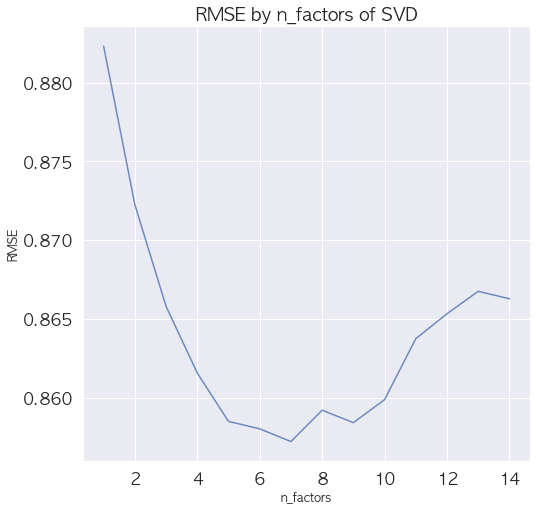

In [123]:
plt.plot(range(1, 15), rmse_list_by_factors, alpha=0.8)
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

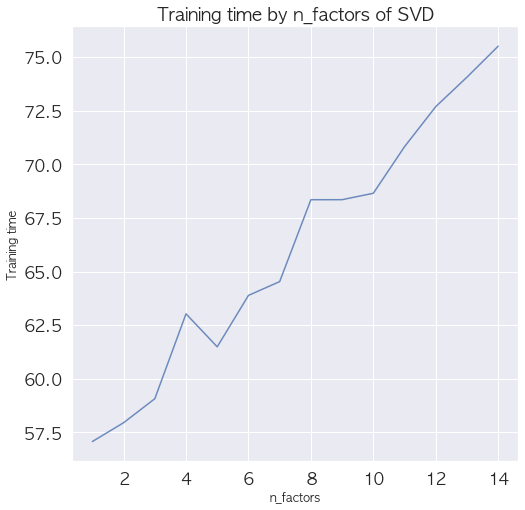

In [124]:
#실제 평점과의 비교 시각화
plt.plot(range(1, 15), ttime_list_by_factors, alpha=0.8)
plt.title('Training time by n_factors of SVD')
plt.ylabel('Training time', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

In [125]:
# 타겟 유저 정보를 테스트 데이터로 생성합니다.
test_data = []
for index, row in movie_data.iterrows():
    movie_id = row['movie_id']
    if movie_id in target_user_movie_rating_dict:
        rating = target_user_movie_rating_dict[movie_id]
        test_data.append((target_user_id, movie_id, rating))
        
# 타겟 유저의 평점 점수를 예측합니다.
target_user_predictions = model.test(test_data)

# 예측된 점수 중, 타겟 유저의 영화별 점수를 target_user_movie_predict_dict로 저장합니다.
def get_user_predicted_ratings(predictions, user_id, user_history):
    target_user_movie_predict_dict = {}
    for uid, mid, rating, predicted_rating, _ in predictions:
        if user_id == uid:
            if mid in user_history:
                target_user_movie_predict_dict[mid] = predicted_rating
    return target_user_movie_predict_dict

# target_user_movie_predict_dict에서 예측된 점수 중, 타겟 유저의 Top 10 영화를 선정합니다.
target_user_movie_predict_dict = get_user_predicted_ratings(predictions=target_user_predictions, 
                                                            user_id=target_user_id, 
                                                            user_history=target_user_movie_rating_dict)
target_user_movie_predict_dict

{260: 4.359381473905197,
 480: 3.638209316541071,
 1036: 4.042826730893141,
 1097: 4.152219672193692,
 1196: 4.073447428514971,
 1198: 4.5905769287891305,
 1201: 4.483011486175077,
 1210: 3.5706702004550177,
 1214: 4.028600843237352,
 1240: 4.256654370005734,
 1387: 4.502566785671132,
 1954: 4.520921766603957,
 2028: 4.7322161399837235,
 2366: 4.269872263243422,
 2692: 4.311591971035709,
 2947: 4.208140176523792,
 2951: 4.186144384094338,
 3418: 3.891029859337616,
 3468: 4.734936330438857,
 3527: 3.0071195974747997,
 3702: 3.4192465374776186}

In [126]:
# 예측 점수와 실제 점수를 영화 타이틀에 매핑합니다.
origin_rating_list = []
predicted_rating_list = []
movie_title_list = []
idx = 0
for movie_id, predicted_rating in target_user_movie_predict_dict.items():
    idx = idx + 1
    predicted_rating = round(predicted_rating, 2)
    origin_rating = target_user_movie_rating_dict[movie_id]
    movie_title = movie_dict[movie_id]
    print("movie", str(idx), ":", movie_title, "-", origin_rating, "/", predicted_rating)
    origin_rating_list.append(origin_rating)
    predicted_rating_list.append(predicted_rating)
    movie_title_list.append(str(idx))

movie 1 : Star Wars: Episode IV - A New Hope (1977) - 5 / 4.36
movie 2 : Jurassic Park (1993) - 4 / 3.64
movie 3 : Die Hard (1988) - 4 / 4.04
movie 4 : E.T. the Extra-Terrestrial (1982) - 4 / 4.15
movie 5 : Star Wars: Episode V - The Empire Strikes Back (1980) - 2 / 4.07
movie 6 : Raiders of the Lost Ark (1981) - 5 / 4.59
movie 7 : Good, The Bad and The Ugly, The (1966) - 5 / 4.48
movie 8 : Star Wars: Episode VI - Return of the Jedi (1983) - 3 / 3.57
movie 9 : Alien (1979) - 4 / 4.03
movie 10 : Terminator, The (1984) - 5 / 4.26
movie 11 : Jaws (1975) - 5 / 4.5
movie 12 : Rocky (1976) - 5 / 4.52
movie 13 : Saving Private Ryan (1998) - 5 / 4.73
movie 14 : King Kong (1933) - 4 / 4.27
movie 15 : Run Lola Run (Lola rennt) (1998) - 5 / 4.31
movie 16 : Goldfinger (1964) - 5 / 4.21
movie 17 : Fistful of Dollars, A (1964) - 4 / 4.19
movie 18 : Thelma & Louise (1991) - 4 / 3.89
movie 19 : Hustler, The (1961) - 5 / 4.73
movie 20 : Predator (1987) - 1 / 3.01
movie 21 : Mad Max (1979) - 4 / 3.42


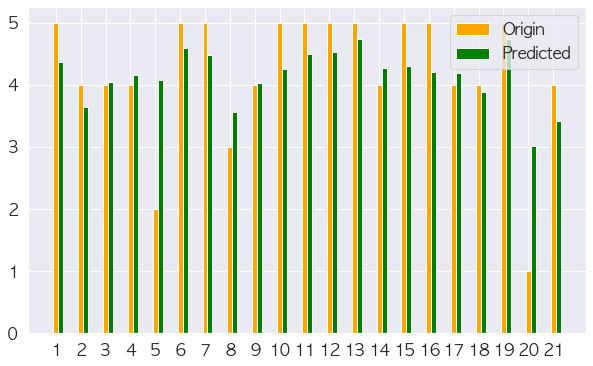

In [127]:
# 실제 점수와 예측 점수를 리스트로 추출합니다.
origin = origin_rating_list
predicted = predicted_rating_list
 
# 영화의 개수만큼 bar 그래프의 index 개수를 생성합니다.
plt.rcParams['figure.figsize'] = (10,6)
index = np.arange(len(movie_title_list))
bar_width = 0.2
 
# 실제 점수와 예측 점수를 bar 그래프로 출력합니다.
rects1 = plt.bar(index, origin, bar_width,
                 color='orange',
                 label='Origin')
rects2 = plt.bar(index + bar_width, predicted, bar_width,
                 color='green',
                 label='Predicted')
plt.xticks(index, movie_title_list)
plt.legend()
plt.show()

### 20대가 좋아할 만한 영화 예측

In [128]:
user_age_20_list = user_data[user_data['ages']=="20"]['user_id'].tolist()

# 평가하지 않은 user-movie rating들에 대한 예측값을 계산합니다.
preprocess_start = time.time()
test_data = train_data.build_anti_testset()
predictions = model.test(test_data)

# 평가하지 않은 user-movie rating 중에서, 20대의 예측값을 선별합니다.
hidden_user_age_20_movie_predict_dict = {}
for uid, mid, _, predicted_rating, _ in predictions:
    if uid in user_age_20_list:
        if mid in hidden_user_age_20_movie_predict_dict:
            hidden_user_age_20_movie_predict_dict[mid]['sum'] += predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] += 1
        else:
            hidden_user_age_20_movie_predict_dict[mid] = {}
            hidden_user_age_20_movie_predict_dict[mid]['sum'] = predicted_rating
            hidden_user_age_20_movie_predict_dict[mid]['count'] = 1

# 영화마다 20대 유저의 rating 평균값을 계산합니다.
for movie_id, score_dict in hidden_user_age_20_movie_predict_dict.items():
    score_dict['mean'] = score_dict['sum'] / score_dict['count']
    
# Top 10 movie_id를 추출합니다.
hidden_user_age_20_movie_list = sorted(hidden_user_age_20_movie_predict_dict, 
                                       key=lambda x: (hidden_user_age_20_movie_predict_dict[x]['mean']), 
                                       reverse=True)[:10]

preprocess_end = time.time()
print("preprocess time: %.2f seconds" % (preprocess_end - preprocess_start))

preprocess time: 483.35 seconds


In [129]:
# 선정된 리스트를 출력합니다.
print("20대가 좋아할지도 모르는 영화 Top 10")
print("---------------------------------")
for movie_id in hidden_user_age_20_movie_list:
    movie_title = movie_dict[movie_id]
    age_20_rating = hidden_user_age_20_movie_predict_dict[movie_id]['mean']
    print("title:", movie_title, "| rating:", age_20_rating)

20대가 좋아할지도 모르는 영화 Top 10
---------------------------------
title: Sanjuro (1962) | rating: 4.660835077740359
title: Lamerica (1994) | rating: 4.529381313281839
title: For All Mankind (1989) | rating: 4.527863239985826
title: Shawshank Redemption, The (1994) | rating: 4.507680061676142
title: Schindler's List (1993) | rating: 4.460234498011431
title: Usual Suspects, The (1995) | rating: 4.441555583023749
title: Bandits (1997) | rating: 4.428437170027151
title: Wrong Trousers, The (1993) | rating: 4.397589997000116
title: Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954) | rating: 4.386923570187463
title: Rear Window (1954) | rating: 4.385637970793317


## KNN을 이용한 회귀

In [130]:
from sklearn.neighbors import KNeighborsRegressor

#모델 생성 - 이웃의 개수는 3개, 가중 평균 이용(weights 의 값을 uniform으로 설정하면 일반 평균)
regressor = KNeighborsRegressor(n_neighbors = 3, weights = "distance")

#피처 와 레이블 생성
training_points = [
  [0.5, 0.2, 0.1],
  [0.9, 0.7, 0.3],
  [0.4, 0.5, 0.7]
]
training_labels = [5.0, 6.8, 9.0]

#모델 훈련
regressor.fit(training_points, training_labels)

unknown_points = [
  [0.2, 0.1, 0.7],
  [0.4, 0.7, 0.6],
  [0.5, 0.8, 0.1]
]

#예측
guesses = regressor.predict(np.array(unknown_points))
print(guesses)

[7.28143288 7.76451922 6.8457845 ]


## Decision Tree

### 의사 결정 나무

In [131]:
#모델 생성 및 훈련
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

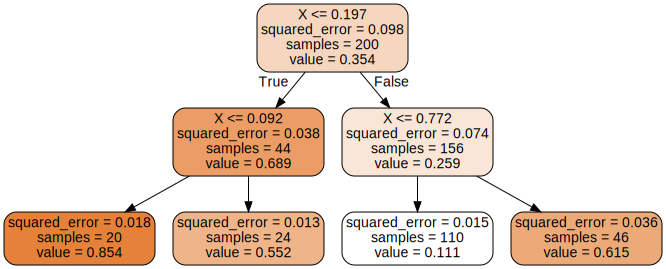

In [132]:
#모델 시각화
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg,
        out_file="decision_tree.dot",
        feature_names=["X"],
        class_names="y",
        rounded=True,
        filled=True
    )

with open('decision_tree.dot') as f:
    dot_graph = f.read()
src = Source(dot_graph)

src

그림 저장: tree_regression_plot


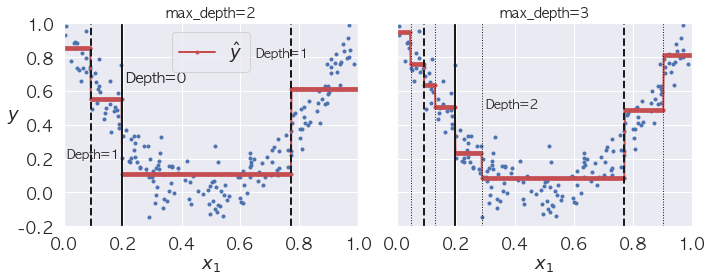

In [133]:
# max-depth 변화
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")
    
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])    
plot_regression_predictions(tree_reg1, X, y)

for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

save_fig("tree_regression_plot")
plt.show()


그림 저장: tree_regression_regularization_plot


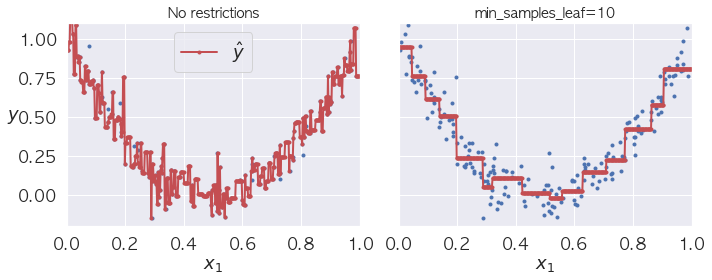

In [134]:
# 하이퍼 파라미터 조절
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

save_fig("tree_regression_regularization_plot")
plt.show()


### 보스톤 집 값 예측

In [135]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['PRICE'] = boston.target

X_feature = bostonDF['RM'].values.reshape(-1,1)
y_target = bostonDF['PRICE'].values.reshape(-1,1)


tree = DecisionTreeRegressor(max_depth=100)
tree.fit(X_feature, y_target)

y_pred = tree.predict(X_feature)
print("MSE:", mean_squared_error(y_target, y_pred))
print("결정계수:", r2_score(y_target, y_pred))

neg_mse_scores = cross_val_score(tree, X_feature, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

MSE: 4.442921607378129
결정계수: 0.9473709433018188
 5 교차 검증의 개별 Negative MSE scores:  [ -38.57  -58.98  -75.84 -102.68  -87.09]
 5 교차 검증의 개별 RMSE scores :  [ 6.21  7.68  8.71 10.13  9.33]
 5 교차 검증의 평균 RMSE : 8.413 


### 선형 회귀 와 비교

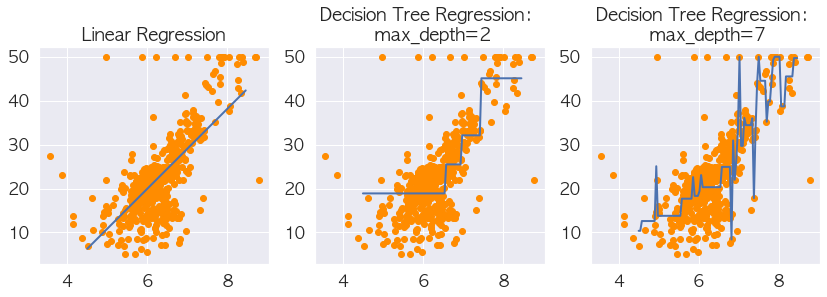

In [136]:
# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트을 4.5 ~ 8.5 까지 100개 데이터 세트 생성. 
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF['RM'].values.reshape(-1,1)
y_target = bostonDF['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행. 
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

fig , (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

# X축값을 4.5 ~ 8.5로 변환하며 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF.RM, bostonDF.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr,label="linear", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF.RM, bostonDF.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:3", linewidth=2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF.RM, bostonDF.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

## SVM을 이용한 회귀

### 선형 SVM

In [137]:
#시드 고정 후 가우시안 분포를 따르는 데이터셋을 만듭니다.
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m,1)
y = (4+3*X+np.random.randn(m,1)).ravel()

X_train = X[:40]
X_test = X[40:]

y_train = y[:40]
y_test = y[40:]

In [138]:
# 모델 생성 과 훈련
from sklearn.svm import LinearSVR
# svm_reg1 = 마진이 큰 모형(epsilon=1.5)
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_train,y_train)

LinearSVR(epsilon=1.5, random_state=42)

In [139]:
# 예측 및 결과 비교
y_pred = svm_reg.predict(X_test)
print(y_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

[4.51255752 7.32817403 5.68422517 8.93765219 4.74418629 7.47337666
 6.78566857 7.44915924 6.75050147 5.62239417]
[4.21074507 6.48935892 3.6755021  9.01837335 5.04577413 7.51127252
 5.36900389 6.64135932 6.80405331 4.59433948]
0.9299366061913275


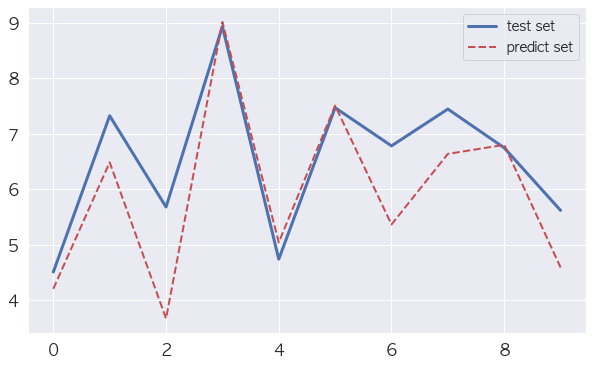

In [140]:
plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()

### 모형 변경

In [141]:
#마진이 작은 모형(epsilon=0.5)
svm_reg = LinearSVR(epsilon=0.5, random_state=42)
svm_reg.fit(X,y)

y_pred = svm_reg.predict(X_test)
print(y_test)
print(y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

[4.51255752 7.32817403 5.68422517 8.93765219 4.74418629 7.47337666
 6.78566857 7.44915924 6.75050147 5.62239417]
[4.5983454  6.89197353 4.0595756  9.43765219 5.43887665 7.92062074
 5.76423624 7.0449755  7.20874151 4.98446739]
0.7478878025547229


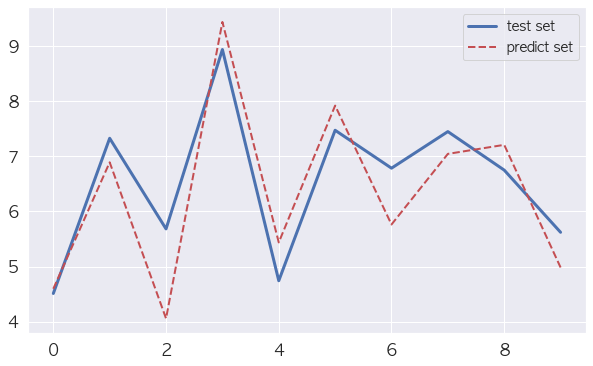

In [142]:
plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()

### 비선형 SVM

In [143]:
# 데이터 생성
np.random.seed(42)
m = 100
X = 2* np.random.rand(m,1) -1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m,1) / 10).ravel()

X_train = X[:80]
X_test = X[80:]

y_train = y[:80]
y_test = y[80:]

[0.72288633 0.30244777 0.10424021 0.55932966 0.13618366 0.30486687
 0.46721879 0.18328738 0.67364758 0.2372651  0.49554194 0.52327493
 0.36363588 0.14439161 0.31208842 0.11725508 0.19786996 0.23012401
 0.58320692 0.51179488]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.4055248767954734


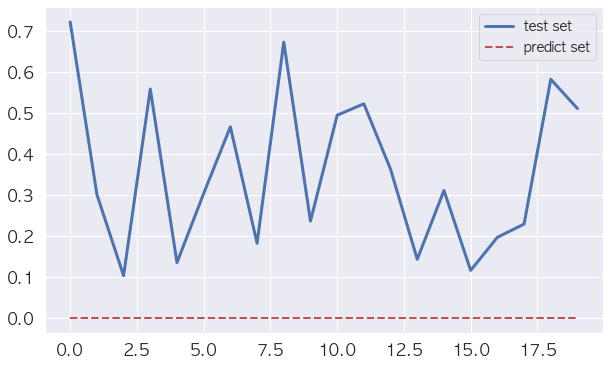

In [145]:
# svm_reg1 = 마진이 큰 모형(epsilon=1.5)
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X_train,y_train)

# 예측 및 결과 비교
y_pred = svm_reg.predict(X_test)
print(y_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()

[0.72288633 0.30244777 0.10424021 0.55932966 0.13618366 0.30486687
 0.46721879 0.18328738 0.67364758 0.2372651  0.49554194 0.52327493
 0.36363588 0.14439161 0.31208842 0.11725508 0.19786996 0.23012401
 0.58320692 0.51179488]
[0.4651027  0.19846537 0.22908124 0.59914459 0.24538513 0.23357404
 0.28422647 0.20696826 0.50645469 0.16547812 0.4945102  0.26766324
 0.31917833 0.17229685 0.33155532 0.16380133 0.16489467 0.17571528
 0.6785716  0.51517657]
0.11454023807854878


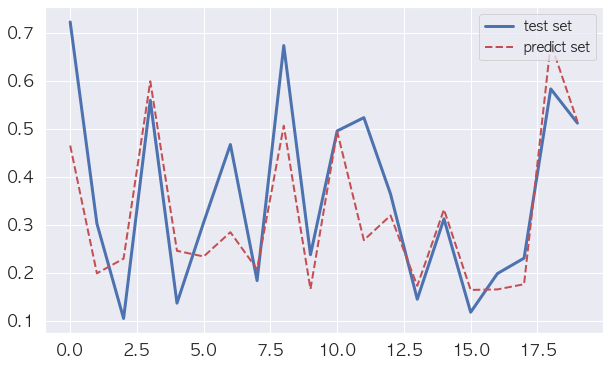

In [146]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel='poly', gamma='auto', degree=2, C=10, epsilon=0.1)

svm_poly_reg.fit(X_train,y_train)

# 예측 및 결과 비교
y_pred = svm_poly_reg.predict(X_test)
print(y_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

plt.plot(y_test, "b-", linewidth=3, label="test set")
plt.plot(y_pred, "r--", linewidth=2, label="predict set")
plt.legend(loc="upper right", fontsize=14)
plt.show()